In [1]:
from dask.distributed import Client
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(cores=28, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='120GB', interface='ib0'
#                       ) 
# cluster.scale(196)
# # cluster.adapt(minimum=10, maximum=196)

# c = Client(cluster)
c = Client()
c

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:41729' processes=8 threads=56, memory=270.19 GB>

In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(c.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11344593      visu      viz  tuchida  R      47:23      1 n4367
8


In [3]:
import xarray as xr
import numpy as np
import xscale
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path as op
from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [5]:
alpha = 2.1e-4
rhoConst = 999.8
g = 9.81
cp = 3929.245
ncoars = 5
ys,ye = (2000-1,2500+1)
xs,xe = (2300-1,3100+1)
Sys,Sye = (1100,1600)
Sxs,Sxe = (2200,3000)

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                        ).isel(t=0)
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))

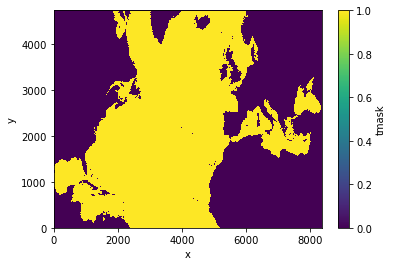

In [6]:
dsmask.tmask[0].plot()

In [6]:
At = (dsmask.e1t * dsmask.e2t).isel(y=slice(ys,ye),x=slice(xs,xe))
Au = (dsmask.e1u * dsmask.e2u).isel(y=slice(ys,ye),x=slice(xs,xe))
Av = (dsmask.e1v * dsmask.e2v).isel(y=slice(ys,ye),x=slice(xs,xe))
e1u = dsmask.e1u.isel(y=slice(ys,ye),x=slice(xs,xe))
e2u = dsmask.e2u.isel(y=slice(ys,ye),x=slice(xs,xe))
e1v = dsmask.e1v.isel(y=slice(ys,ye),x=slice(xs,xe))
e2v = dsmask.e2v.isel(y=slice(ys,ye),x=slice(xs,xe))
e2t = dsmask.e2t.isel(y=slice(ys,ye),x=slice(xs,xe))
e1t = dsmask.e1t.isel(y=slice(ys,ye),x=slice(xs,xe))
e3t = dsmask.e3t_1d
e3w = dsmask.e3w_1d
# At

In [7]:
e1tb = e1t.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                              boundary='trim').sum(skipna=True)
e2tb = e2t.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                              boundary='trim').sum(skipna=True)
e1ub = e1u.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                              boundary='trim').sum(skipna=True)
e2vb = e2v.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                              boundary='trim').sum(skipna=True)
Aub = Au.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                            boundary='trim').sum(skipna=True)
Avb = Av.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                            boundary='trim').sum(skipna=True)
Atb = At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                            boundary='trim').sum(skipna=True)

In [8]:
cori = xr.apply_ufunc(gsw.f, dsmask.nav_lat.isel(y=slice(ys,ye),x=slice(xs,xe)))
fb = xr.apply_ufunc(gsw.f,(dsmask.nav_lat.isel(y=slice(ys+1,ye-1),x=slice(xs+1,xe-1))
                           * At.isel(y=slice(1,-1),x=slice(1,-1))
                          ).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
                           / Atb
                   )
# fb

In [9]:
dsU = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridU_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(depthu=slice(None,810))
dsV = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridV_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(depthv=slice(None,810))
dsW = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridW_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(depthw=slice(None,810))

maskT = dsmask.tmask.sel(y=slice(ys,ye),x=slice(xs,xe)).isel(z=slice(None,len(dsW.depthw)))
maskU = dsmask.umask.sel(y=slice(ys,ye),x=slice(xs,xe)).isel(z=slice(None,len(dsU.depthu)))
maskV = dsmask.vmask.sel(y=slice(ys,ye),x=slice(xs,xe)).isel(z=slice(None,len(dsV.depthv)))

dsT = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridT_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(deptht=slice(None,810))
dsS = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridS_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(deptht=slice(None,810))

In [11]:
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
cartopy.config['pre_existing_data_dir']  = '/scratch/cnt0024/hmg2840/albert7a/DEV/git/cartopy_data'

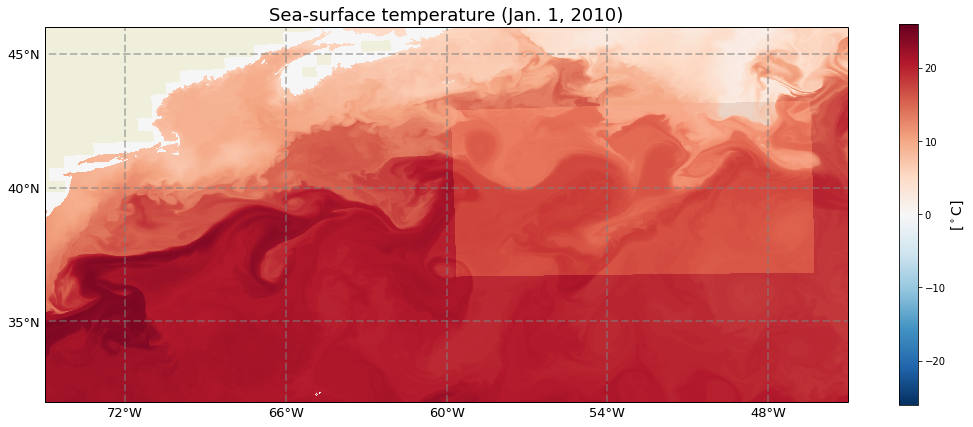

In [12]:
sst = dsT.votemper.isel(deptht=0)

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent([-75,-45,32,46], crs=ccrs.PlateCarree())
im = ax.pcolor(dsmask.nav_lon.sel(y=slice(ys-500,ye+300),x=slice(xs-950,xe+100)), 
               dsmask.nav_lat.sel(y=slice(ys-500,ye+300),x=slice(xs-950,xe+100)), 
              sst[3].sel(y=slice(ys-500,ye+300),x=slice(xs-950,xe+100)),
              cmap='RdBu_r', vmin=-26, vmax=26, rasterized=True, transform=ccrs.PlateCarree())
ax.pcolor(dsmask.nav_lon.sel(y=slice(ys,ye),x=slice(xs,xe)), 
         dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)), 
         sst[3].sel(y=slice(ys,ye),x=slice(xs,xe)),
         cmap='coolwarm', vmin=-24, vmax=24, rasterized=True, transform=ccrs.PlateCarree())
# ax.pcolor(dsmask.nav_lon.sel(y=slice(Sys,Sye),x=slice(Sxs,Sxe)), 
#          dsmask.nav_lat.sel(y=slice(Sys,Sye),x=slice(Sxs,Sxe)), 
#          sst[3].sel(y=slice(Sys,Sye),x=slice(Sxs,Sxe)),
#          cmap='YlOrRd', vmin=17, vmax=28, alpha=1., rasterized=True)

ax.add_feature(cfeature.LAND)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# gl.xlines = False
gl.ylocator = mticker.FixedLocator([30,35,40,45,50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'k'}
gl.ylabel_style = {'size': 13, 'color': 'k'}
# ax.coastlines()
ax.set_xlabel(r"Longitude", fontsize=16)
ax.set_ylabel(r"Latitude", fontsize=16)
ax.set_title(r"Sea-surface temperature (Jan. 1, 2010)", fontsize=18)
cbar = fig.colorbar(im, shrink=.7)
cbar.set_label(r"[$^\circ$C]", fontsize=14)
plt.savefig(r"/scratch/cnt0024/hmg2840/tuchida/Figs/SST_Jan-01-2010_GulfStream.pdf")

In [9]:
dsTflx = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_flxT_20100101-20100101.nc'),
                         chunks={'time_counter':1}
                        )
dsTflx

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 24, x: 8354, y: 4729)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    qt_oce                (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    qsr_oce               (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    solhflup              (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    sowaflup              (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    sowafld               (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    taubot                (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
Attributes:
    name:         /scratch/tmp/5251284/eNATL60-BLBT02X_1h_20100101_20100125_flxT
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Mar-23 13:40:41 GMT
    uuid:         37ceed73-e6f0-4669-999d-ab9bd4bb4772
    ibegin:       0
    ni:           8354
    jbegin:       0
    nj:           10
    file_name:    eNATL60-BLBT02X_1h_20100101_20100125_flxT_20100101-20100101.nc
    TimeStamp:    25/03/2019 15:05:52 +0100

In [10]:
d2D = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridT-2D_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     )
d2Du = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridU-2D_20100101-20100101.nc'),
                       chunks={'time_counter':1}
                      )
d2Dv = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridV-2D_20100101-20100101.nc'),
                       chunks={'time_counter':1}
                      )
d2Du

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 24, x: 8354, y: 4729)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    sozotaux              (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    sozocrtx              (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    bozocrtx              (time_counter, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
Attributes:
    name:         /scratch/tmp/5251284/eNATL60-BLBT02X_1h_20100101_20100125_g...
    description:  ocean U grid variables
    title:        ocean U grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Mar-23 13:40:48 GMT
    uuid:         287e92fb-7f64-41da-a980-aa59c5566abe
    ibegin:       0
    ni:           8354
    jbegin:       0
    nj:           10
    file_name:    eNATL60-BLBT02X_1h_20100101_20100125_gridU-2D_20100101-2010...
    TimeStamp:    24/03/2019 14:43:32 +0100

In [11]:
CT = dsT.votemper.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).isel(time_counter=-1).where(xr.DataArray(maskT.data, dims=['deptht','y','x'])!=0.)
SA = dsS.vosaline.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).isel(time_counter=-1).where(xr.DataArray(maskT.data, dims=['deptht','y','x'])!=0.)
w = dsW.vovecrtz.sel(y=slice(ys,ye),x=slice(xs,xe)
                    ).isel(time_counter=-1).where(xr.DataArray(maskT.data, dims=['depthw','y','x'])!=0.)
v = dsV.vomecrty.sel(y=slice(ys,ye),x=slice(xs,xe)
                    ).isel(time_counter=-1).where(xr.DataArray(maskV.data, dims=['depthv','y','x'])!=0.)
u = dsU.vozocrtx.sel(y=slice(ys,ye),x=slice(xs,xe)
                    ).isel(time_counter=-1).where(xr.DataArray(maskU.data, dims=['depthu','y','x'])!=0.)

In [13]:
qtot = dsTflx.qt_oce.sel(y=slice(ys,ye),x=slice(xs,xe)
                        ).isel(time_counter=-1).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                            ) != 0.)
stot = dsTflx.sowaflup.sel(y=slice(ys,ye),x=slice(xs,xe)
                          ).isel(time_counter=-1).where(xr.DataArray(maskT[0].data, dims=['y','x']
                                              ) != 0.)
alpha_s = xr.apply_ufunc(gsw.alpha, SA.isel(deptht=0), CT.isel(deptht=0), 0.,
                         dask='parallelized', output_dtypes=['float',])
beta_s = xr.apply_ufunc(gsw.beta, SA.isel(deptht=0), CT.isel(deptht=0), 0.,
                        dask='parallelized', output_dtypes=['float',])
sig0_s = xr.apply_ufunc(gsw.sigma0, SA.isel(deptht=0), CT.isel(deptht=0), 
                        dask='parallelized', output_dtypes=[float,])
# Positive values defined as destablizing conditions
Bo_t = g * alpha_s * (-qtot) * ((sig0_s+1e3)*cp)**-1
Bo_s = g * beta_s * stot * SA.isel(deptht=0)
print(Bo_t, Bo_s)

<xarray.DataArray (time_counter: 24, y: 502, x: 802)>
dask.array<mul, shape=(24, 502, 802), dtype=float64, chunksize=(1, 502, 802), chunktype=numpy.ndarray>
Coordinates:
    deptht         float64 0.4805
    nav_lat        (y, x) float32 36.682133 36.682335 ... 43.229923 43.230286
    nav_lon        (y, x) float32 -59.63978 -59.6231 ... -46.448288 -46.431477
    time_centered  (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: y, x <xarray.DataArray (time_counter: 24, y: 502, x: 802)>
dask.array<mul, shape=(24, 502, 802), dtype=float64, chunksize=(1, 502, 802), chunktype=numpy.ndarray>
Coordinates:
    deptht         float64 0.4805
    nav_lat        (y, x) float32 36.682133 36.682335 ... 43.229923 43.230286
    nav_lon        (y, x) float32 -59.63978 -59.6231 ... -46.448288 -46.431477
    time_centered  (time_counter) datetime64[ns] 2010-0

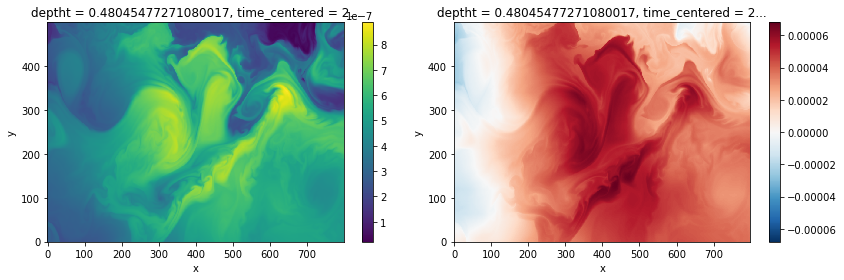

In [29]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
Bo_t[0].plot(ax=ax1)
Bo_s[0].plot(ax=ax2)

In [12]:
ssh = d2D.sossheig.sel(y=slice(ys,ye),x=slice(xs,xe)
                      ).isel(time_counter=-1).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                          ) != 0.)
taux = d2Du.sozotaux.sel(y=slice(ys,ye),x=slice(xs,xe)
                        ).isel(time_counter=-1).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                            ) != 0.)
tauy = d2Dv.sometauy.sel(y=slice(ys,ye),x=slice(xs,xe)
                        ).isel(time_counter=-1).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                            ) != 0.)
tauy

<xarray.DataArray 'sometauy' (y: 502, x: 802)>
dask.array<where, shape=(502, 802), dtype=float32, chunksize=(502, 802), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(502, 802), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(502, 802), meta=np.ndarray>
    time_centered  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       surface_downward_y_stress
    long_name:           Wind Stress along j-axis
    units:               N/m2
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

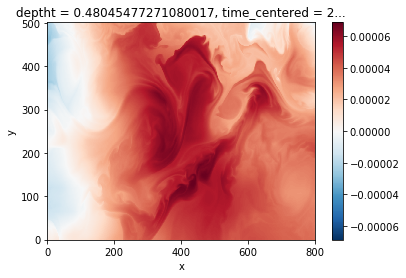

In [15]:
Bo = Bo_t + Bo_s
Bo[0].plot()

<xarray.DataArray (deptht: 95, y: 502, x: 802)>
dask.array<mul, shape=(95, 502, 802), dtype=float64, chunksize=(95, 502, 802), chunktype=numpy.ndarray>
Coordinates:
  * deptht        (deptht) float64 0.4805 1.559 2.794 ... 774.7 790.2 805.8
    nav_lat       (y, x) float32 36.682133 36.682335 ... 43.229923 43.230286
    nav_lon       (y, x) float32 -59.63978 -59.6231 ... -46.448288 -46.431477
    time_counter  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x


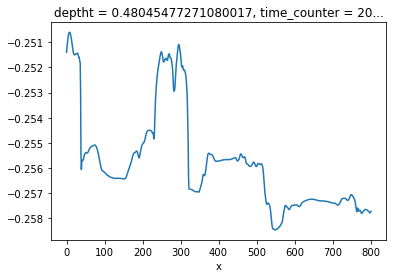

In [15]:
# sig0 = xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float,])
# buoy = -g*xr.apply_ufunc(gsw.sigma0, SA.load(), CT.load())*1e-3
rho0, alpha0, beta0 = gsw.rho_alpha_beta(SA[0], CT[0], 0)
alpha0 = xr.DataArray(alpha0, dims=SA[0].dims, coords=SA[0].coords)
beta0 = xr.DataArray(beta0, dims=SA[0].dims, coords=SA[0].coords)
buoy = -g*(xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float,])
           + 1e3 - rhoConst)*rhoConst**-1
print(buoy)
buoy[0,0].plot()

In [20]:
# pres = xr.apply_ufunc(gsw.p_from_z, -SA.deptht, SA.nav_lat.load())
# # alpha = xr.apply_ufunc(gsw.alpha, SA.load(), CT.load(), pres)
# pres.mean(dim=['y','x']).plot()

In [ ]:
win = At.window
win.set(window='hanning', dim=['y','x'], n=[30,30])
weight = win.boundary_weights(drop_dims=[])
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.set_tight_layout(True)
win.convolve(weights=weight).plot(ax=ax1)
(At - win.convolve(weights=weight)).plot(ax=ax2)

In [13]:
def filt(da, area=None):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    da_SS = da - da_LS
    
    return da_SS

In [16]:
us = xr.DataArray(filt(u.chunk({'depthu':1}), area=Au).data, dims=['deptht','y','x'],
                  coords={'deptht':CT.deptht.data})
vs = xr.DataArray(filt(v.chunk({'depthv':1}), area=Av).data, dims=['deptht','y','x'],
                  coords={'deptht':CT.deptht.data})
ws = filt(w.chunk({'depthw':1}), area=At)

bs = filt(buoy.chunk({'deptht':1}), area=At)
bm = buoy - bs
ts = filt(CT.chunk({'deptht':1}), area=At)
ss = filt(SA.chunk({'deptht':1}), area=At)
tm = CT - ts
sm = SA - ss

ws

<xarray.DataArray (depthw: 95, y: 502, x: 802)>
dask.array<sub, shape=(95, 502, 802), dtype=float64, chunksize=(1, 502, 802), chunktype=numpy.ndarray>
Coordinates:
  * depthw         (depthw) float64 0.0 1.0 2.157 3.471 ... 767.1 782.4 798.0
    nav_lat        (y, x) float32 dask.array<chunksize=(502, 802), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(502, 802), meta=np.ndarray>
    time_centered  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

In [18]:
vorts = ((vs*e1v).diff('y')[:,:,:-1] - (us*e2u).diff('x')[:,:-1]) * At[:-1,:-1]**-1
vorts

<xarray.DataArray (deptht: 95, y: 501, x: 801)>
dask.array<mul, shape=(95, 501, 801), dtype=float64, chunksize=(1, 501, 801), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 0.4805 1.559 2.794 4.187 ... 774.7 790.2 805.8
Dimensions without coordinates: y, x

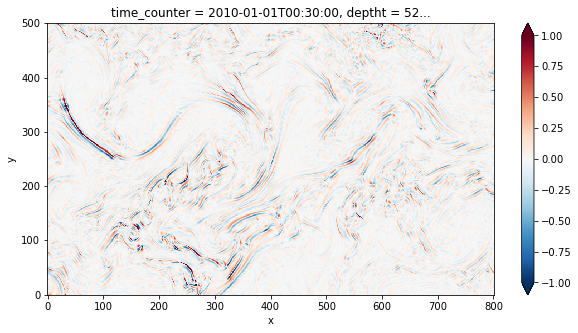

In [53]:
(vorts[0,20]*cori[:-1,:-1]**-1).plot(figsize=(10,5), vmin=-1., vmax=1, cmap='RdBu_r')

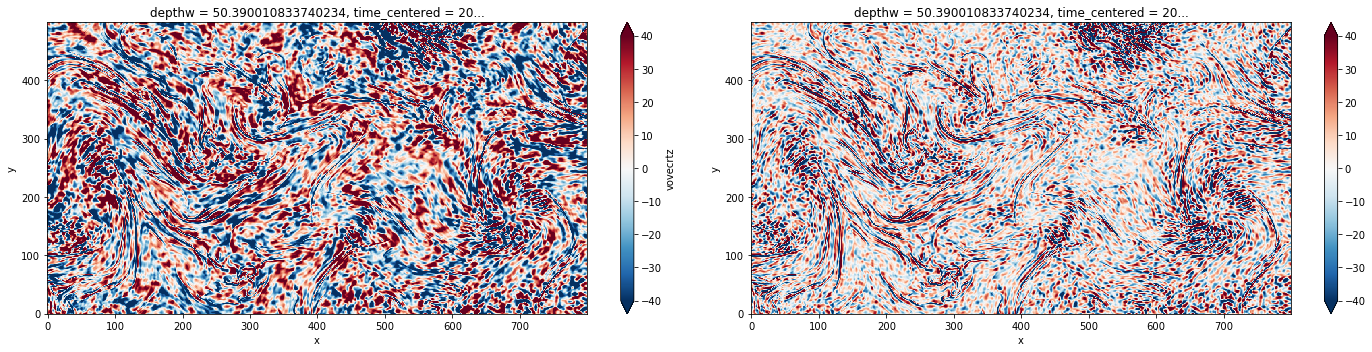

In [20]:
fig, (ax1,ax2) = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(w[0,20]*86400).plot(ax=ax1, vmax=40)
(ws[0,20]*86400).plot(ax=ax2, vmax=40)

Assuming that MLI feeds off of mesoscale fronts ($b_m = b - b_s$), we have:

$$|\langle \nabla_{\text{h}} b_m \rangle|^2\ \ (\neq | \nabla_{\text{h}} \langle b \rangle|^2)$$

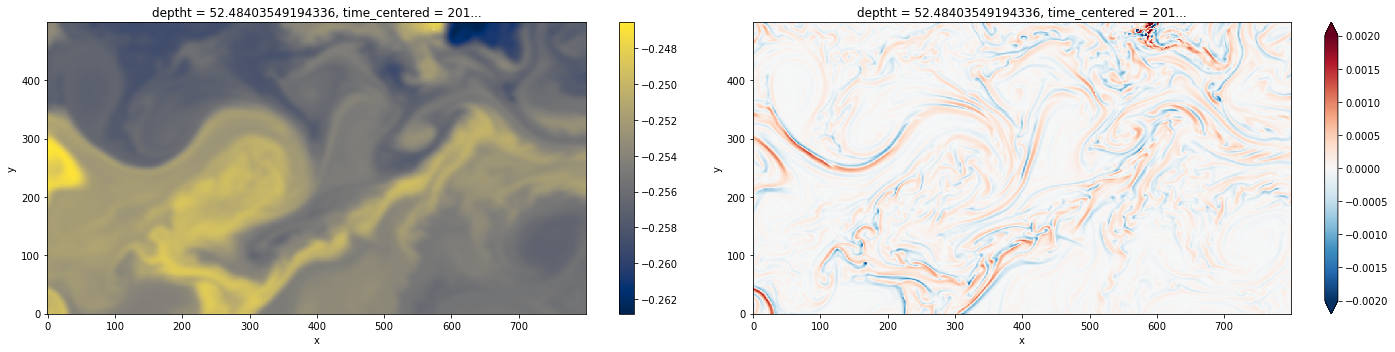

In [21]:
fig, (ax1,ax2) = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(bm[0,20]).plot(ax=ax1, cmap='cividis')
(bs[0,20]).plot(ax=ax2, vmax=2e-3, cmap='RdBu_r')

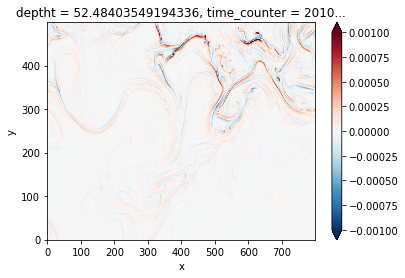

In [16]:
spice[0,20].plot(vmax=1e-3)

In [20]:
# wsbs = ws.isel(depthw=slice(1,None)) * .5*(bs.isel(deptht=slice(1,None)).data 
#                                            + bs.isel(deptht=slice(None,-1)).data
#                                           )  # the horizontal area doesn't change in the vertical
wsbs = (ws.isel(depthw=slice(1,None)) 
        * bs.chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                                         method='linear').data
       )
# wssps = (ws[0].isel(depthw=slice(1,None)) 
#          * spice[0].chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
#                                          method='linear').data
#         )
# wsts = (ws.isel(depthw=slice(1,None)) 
#         * ts.chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
#                                          method='linear').data
#        )
wsbs

<xarray.DataArray (time_counter: 24, depthw: 94, y: 502, x: 802)>
dask.array<mul, shape=(24, 94, 502, 802), dtype=float64, chunksize=(1, 1, 502, 802), chunktype=numpy.ndarray>
Coordinates:
  * depthw         (depthw) float64 1.0 2.157 3.471 4.943 ... 767.1 782.4 798.0
    nav_lat        (y, x) float32 dask.array<chunksize=(502, 802), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(502, 802), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: y, x

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-8bca22c63df2d088a479b23e40aca10b', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-8bca22c63df2d088a479b23e40aca10b', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-a06321b84a1180853da7ff4ac629b78b', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-a06321b84a1180853da7ff4ac629b78b', 0, 0, 0, 0)
NoneType: None


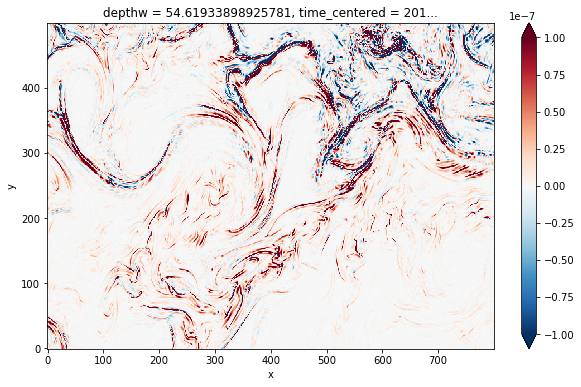

In [21]:
wssps[20].plot(figsize=(10,6), cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-c62bff50c65df88c4461dd63c0e985ba', 0, 0, 0, 0)": []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-c62bff50c65df88c4461dd63c0e985ba', 0, 0, 0, 0)
NoneType: None


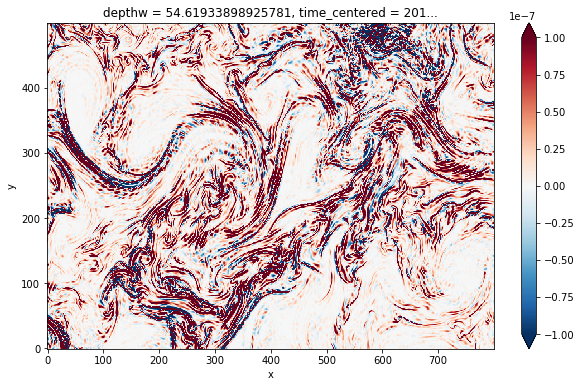

In [39]:
wsbs[0,20].plot(figsize=(10,6), cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

In [19]:
s_b = ((SA*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                        boundary='trim').sum(skipna=True)
       / At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                     boundary='trim').sum(skipna=True)
      )
t_b = ((CT*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                        boundary='trim').sum(skipna=True)
       / At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                     boundary='trim').sum(skipna=True)
      )
# qtot_b = ((qtot*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
#           / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
#          )
# s_b.nbytes*1e-9

In [21]:
# pres = xr.apply_ufunc(gsw.p_from_z, -CT.deptht, CT.nav_lat[2::5,2::5], dask='parallelized', output_dtypes=[float])
# # N2, pN2 = xr.apply_ufunc(gsw.Nsquared, s_b, t_b, pres, kwargs={'lat':CT.nav_lat[2::5,2::5],'axis':1}, 
# #                          dask='parallelized', output_dtypes=[float])
# N2, pN2 = gsw.Nsquared(s_b, t_b, pres, lat=CT.nav_lat[2::5,2::5], axis=1)
# # N2

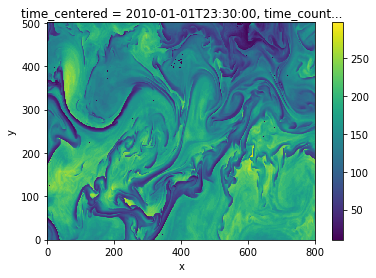

In [20]:
z10 = 6
sig0 = xr.apply_ufunc(gsw.sigma0, SA, CT, 
                      dask='parallelized', output_dtypes=[float,])
nMLD = z10 + np.abs((sig0.isel(deptht=slice(z10,None))
                     - sig0.isel(deptht=z10)
                    ) - 0.03).argmin(dim='deptht').compute()
e3w = dsmask.e3w_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
e3t = dsmask.e3t_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)


# MLD_b = (xr.ones_like(sig0_b) * sig0_b.deptht
#         ).isel(deptht=nMLD_b.persist())
# MLD_b = (xr.ones_like(sig0_b) * sig0_b.deptht
#         )[{'deptht':nMLD_b}]
MLD = e3t.where(e3t.z<=nMLD.compute()).sum('z',skipna=True).compute()
MLD.plot()

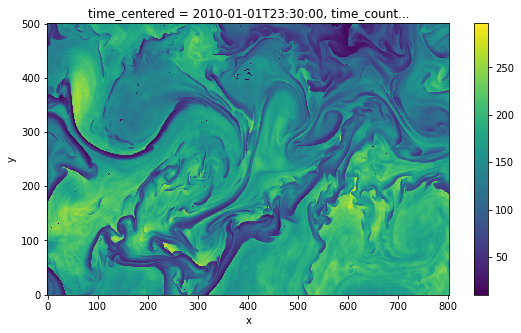

In [21]:
MLD[:,:].plot(figsize=(9,5))

In [21]:
z10 = 6
sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                        dask='parallelized', output_dtypes=[float,])
b_b = -g*sig0_b*1e-3
nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                       - sig0_b.isel(deptht=z10)
                      )-0.03).argmin(dim='deptht').compute()
# nXLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
#                       - sig0_b.isel(deptht=z10)
#                      )-0.01).argmin(dim='deptht').compute()

nMLD_b

<xarray.DataArray (y: 100, x: 160)>
array([[29, 31, 26, ..., 44, 43, 44],
       [26, 31, 27, ..., 45, 44, 44],
       [25, 31, 27, ..., 46, 44, 44],
       ...,
       [26, 20, 23, ..., 39, 38, 38],
       [25, 23, 22, ..., 36, 37, 38],
       [26, 21, 22, ..., 34, 34, 35]])
Coordinates:
    nav_lat       (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon       (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_counter  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

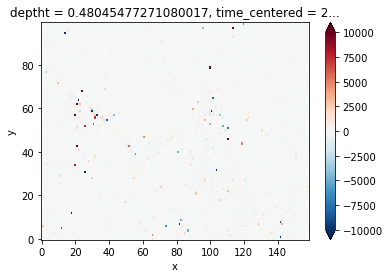

In [54]:
(t_b.diff('x')[0,0]**-1).plot(vmax=1e4)

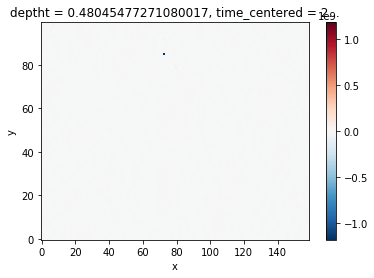

In [51]:
(b_b[0,0].diff('x')**-1).plot()

In [22]:
e3w_b = ((e3w*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True) 
         * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                       boundary='trim').sum(skipna=True)**-1
        )
e3t_b = ((e3t*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(kipna=True) 
         * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                       boundary='trim').sum(skipna=True)**-1
        )

# MLD_b = (xr.ones_like(sig0_b) * sig0_b.deptht
#         ).isel(deptht=nMLD_b.persist())
# MLD_b = (xr.ones_like(sig0_b) * sig0_b.deptht
#         )[{'deptht':nMLD_b}]
MLD_b = e3t_b.where(e3t_b.z<=nMLD_b.compute()).sum('z',skipna=True).compute()
# XLD_b = (xr.ones_like(sig0_b) * sig0_b.deptht
#         )[{'deptht':nXLD_b}]
# del nMLD_b
# MLD_b[0].plot(vmax=1.4e2, vmin=20, cmap='cividis_r')
MLD_b

<xarray.DataArray (y: 100, x: 160)>
array([[100.1467085 , 112.09123688,  83.47986547, ..., 205.89106277,
        197.68486201, 205.89048456],
       [ 83.47731619, 112.09087874,  88.86995562, ..., 214.26223139,
        205.89248035, 205.89169496],
       [ 78.2536457 , 112.09102511,  88.87041657, ..., 222.7961653 ,
        205.89265135, 205.89231555],
       ...,
       [ 83.47027555,  54.61857986,  68.29874863, ..., 166.4872138 ,
        159.10568278, 159.10576927],
       [ 78.24694758,  68.29870191,  63.57325942, ..., 144.83899056,
        151.88946567, 159.10551703],
       [ 83.47024368,  59.01322716,  63.5733493 , ..., 131.23512918,
        131.23517673, 137.95385001]])
Coordinates:
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  datetime64[ns] 2010-01-01T23:30:00
    time_counter   datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

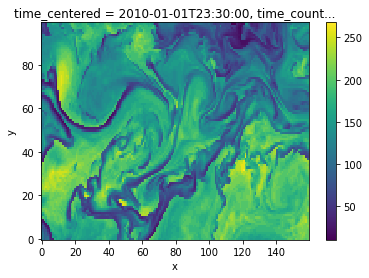

In [24]:
MLD_b[:,:].plot()

In [20]:
XLD_b = t_b.isel({'deptht':nMLD_b})
sML = s_b.isel({'deptht':nMLD_b})
bML = b_b.isel({'deptht':nMLD_b})
tML

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:58244 remote=tcp://127.0.0.1:42785>


<xarray.DataArray (time_counter: 24, y: 100, x: 160)>
dask.array<reshape, shape=(24, 100, 160), dtype=float64, chunksize=(24, 100, 160), chunktype=numpy.ndarray>
Coordinates:
    deptht         (time_counter, y, x) float64 80.84 80.84 ... 127.9 134.6
    nav_lat        (y, x) float32 dask.array<chunksize=(100, 160), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(100, 160), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: y, x

In [19]:
# # zN2 = gsw.z_from_p(pN2, CT.nav_lat[2::5,2::5])
# N2bar = (xr.DataArray(N2, dims=t_b.dims, 
#                       coords={'time_counter':CT.time_counter.data,
#                               'deptht':np.ma.masked_invalid(CT.deptht.rolling(deptht=2).mean()).compressed()
#                              }
#                      ) * xr.DataArray(e3w[1:len(t_b.deptht)].data, dims=['deptht'])
#         ).sum('deptht') * MLD_b**-1
# N2bar

In [36]:
e3w_b

<xarray.DataArray (z: 300, y: 33, x: 53, time_counter: 24)>
array([[[[ 0.92187324,  0.92183907,  0.92179952, ...,  0.92188845,
           0.92191764,  0.92193116],
         [ 0.92189844,  0.92186454,  0.92182524, ...,  0.92191099,
           0.92193953,  0.92195288],
         [ 0.9219032 ,  0.92186525,  0.92182083, ...,  0.92191996,
           0.92195294,  0.92196833],
         ...,
         [ 0.92191073,  0.92189682,  0.92187111, ...,  0.92185608,
           0.92188679,  0.92191225],
         [ 0.92191126,  0.92189872,  0.921875  , ...,  0.92185688,
           0.92188615,  0.92191073],
         [ 0.92191693,  0.92190463,  0.92188044, ...,  0.92185782,
           0.92188764,  0.92191289]],

        [[ 0.9218706 ,  0.92183474,  0.92179312, ...,  0.92190018,
           0.92193236,  0.92194772],
         [ 0.92189918,  0.92186437,  0.92182425, ...,  0.92191733,
           0.92194745,  0.92196151],
         [ 0.92191536,  0.92187576,  0.92182973, ...,  0.92193564,
           0.92197035,  0.921987  ],
         ...,
         [ 0.92190589,  0.92189281,  0.92186878, ...,  0.92185345,
           0.9218822 ,  0.92190619],
         [ 0.92191076,  0.92189831,  0.92187484, ...,  0.92185711,
           0.92188604,  0.92191008],
         [ 0.92191827,  0.92190588,  0.92188172, ...,  0.92185816,
           0.92188862,  0.92191485]],

        [[ 0.92189144,  0.9218571 ,  0.921817  , ...,  0.92191593,
           0.92194704,  0.92196218],
         [ 0.92190313,  0.92187042,  0.92183251, ...,  0.9219248 ,
           0.92195396,  0.92196818],
         [ 0.9219162 ,  0.92188343,  0.92184522, ...,  0.92193373,
           0.92196274,  0.92197645],
         ...,
         [ 0.9219039 ,  0.92189119,  0.92186782, ...,  0.92185313,
           0.92188129,  0.92190493],
         [ 0.92190953,  0.92189689,  0.92187291, ...,  0.92185558,
           0.92188477,  0.9219092 ],
         [ 0.92191457,  0.92190251,  0.92187897, ...,  0.92185797,
           0.92188731,  0.92191224]],

        ...,

        [[ 0.92174637,  0.92169986,  0.92165056, ...,  0.92178906,
           0.92182028,  0.92183011],
         [ 0.92175157,  0.92170602,  0.9216575 , ...,  0.9217923 ,
           0.92182331,  0.92183318],
         [ 0.92175929,  0.92171505,  0.9216678 , ...,  0.92179811,
           0.92182884,  0.92183913],
         ...,
         [ 0.9218073 ,  0.92180168,  0.92178485, ...,  0.92176526,
           0.92178991,  0.92181376],
         [ 0.92181022,  0.92180512,  0.92178913, ...,  0.92176615,
           0.92178964,  0.92181274],
         [ 0.92181384,  0.92180951,  0.92179396, ...,  0.92176618,
           0.92178918,  0.92181208]],

        [[ 0.92174555,  0.9216966 ,  0.92164455, ...,  0.92178841,
           0.92182183,  0.92183302],
         [ 0.92175233,  0.92170517,  0.92165489, ...,  0.92179285,
           0.92182533,  0.92183611],
         [ 0.9217522 ,  0.9217062 ,  0.92165742, ...,  0.92179321,
           0.92182573,  0.92183661],
         ...,
         [ 0.92180661,  0.92180055,  0.92178319, ...,  0.92176079,
           0.92178567,  0.92180988],
         [ 0.92181018,  0.92180551,  0.92178964, ...,  0.92176364,
           0.92178743,  0.92181091],
         [ 0.9218129 ,  0.92180925,  0.92179429, ...,  0.92176459,
           0.92178794,  0.9218113 ]],

        [[ 0.92173662,  0.92168398,  0.92162786, ...,  0.92178864,
           0.9218254 ,  0.92183828],
         [ 0.92174892,  0.92169907,  0.92164575, ...,  0.921793  ,
           0.92182776,  0.92183967],
         [ 0.92175049,  0.92170055,  0.9216478 , ...,  0.9217923 ,
           0.92182644,  0.9218381 ],
         ...,
         [ 0.92180447,  0.92179897,  0.92178127, ...,  0.92175654,
           0.92178201,  0.92180682],
         [ 0.92180946,  0.92180486,  0.92178867, ...,  0.9217605 ,
           0.92178494,  0.92180909],
         [ 0.92181162,  0.92180817,  0.92179354, ...,  0.92176309,
           0.92178662,  0.92180984]]],


       [[[ 1.07834369,  1.07830372,  1.07825746, ...,  1.07836148,
           1.0783

In [25]:
wsbs_b = ((wsbs*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                             boundary='trim').sum(skipna=True) 
          * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                        boundary='trim').sum(skipna=True)**-1
         )
# wstsb_ML = wsts_b.where(wsts_b.depthw <= MLD_b).compute()
# wsbsb_ML = (wsbs_b.where(wsbs_b.depthw <= MLD_b) 
#             * xr.DataArray(e3w[:len(wsbs_b.depthw)], dims='depthw',
#                            coords={'depthw':wsbs_b.depthw.data}
#                           )
#            ).sum('depthw').compute() * MLD_b**-1
wsbsb_ML = (wsbs_b.where(wsbs_b.depthw <= MLD_b) 
            * xr.DataArray(e3w_b.isel(z=slice(1,len(wsbs_b.depthw)+1)), 
                           dims=['depthw','y','x','time_counter'],
                           coords={'depthw':wsbs_b.depthw.data,
                                   'time_counter':wsbs_b.time_counter.data})
           ).sum('depthw', skipna=True) * MLD_b**-1
# wsbsb_ML.nbytes*1e-9

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-3cee092d60b9f4d17c010be13721ffb3', 0, 0, 0, 0)": []} state: [None] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-3cee092d60b9f4d17c010be13721ffb3', 0, 0, 0, 0)
NoneType: None


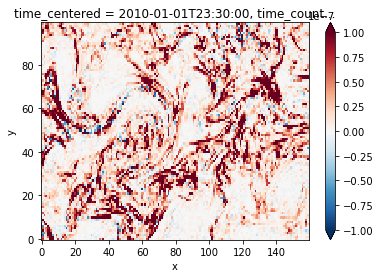

In [45]:
wsbsb_ML[-1].plot(vmax=1e-7)

In [20]:
# wsts_b = ((wsts*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
#           * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
#          )
# # wstsb_ML = wsts_b.where(wsts_b.depthw <= MLD_b).compute()
# wstsb_ML = (wsts_b.where(wsts_b.depthw <= MLD_b) 
#             * xr.DataArray(e3w[:len(wsts_b.depthw)], dims='depthw',
#                            coords={'depthw':wsts_b.depthw.data}
#                           )
#            ).sum('depthw').compute() * MLD_b**-1
# wstsb_ML.nbytes*1e-9

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-aefc0aeb61695aa5a07ebb26408289d4', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-aefc0aeb61695aa5a07ebb26408289d4', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-cc17dfc1ff359adbf995c8e8083a20bf', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-cc17dfc1ff359adbf995c8e8083a20bf', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-aefc0aeb61695aa5a07ebb26408289d4', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-aefc0aeb61695aa5a07ebb26408289d4', 0, 0, 0, 0)
NoneType: None


0.003072

In [26]:
# bb_ML = ((b_b * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#          ).where(b_b.deptht <= MLD_b).sum('deptht') 
#          * MLD_b**-1)
# bb_ML

<xarray.DataArray (time_counter: 24, y: 100, x: 160)>
dask.array<mul, shape=(24, 100, 160), dtype=float64, chunksize=(1, 100, 160), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  (time_counter) datetime64[ns] 2009-10-28T00:30:00 ... 2009-10-28T23:30:00
  * time_counter   (time_counter) datetime64[ns] 2009-10-28T00:30:00 ... 2009-10-28T23:30:00
    deptht         (time_counter, y, x) float64 70.72 86.15 ... 70.72 48.34
Dimensions without coordinates: y, x

In [23]:
# mu1 = 2*(-b_b.deptht) * MLD_b**-1 + 1
# mu1 = mu1.where(mu1.deptht <= MLD_b)
# mu = (1.-mu1**2)*(1.+5/21*mu1**2)
zt_b = e3t_b.isel(z=slice(None,len(dsT.deptht))).cumsum('z',skipna=True)
mu1 = 2*(-zt_b) * MLD_b**-1 + 1
mu1 = mu1.where(zt_b <= MLD_b)
mu = xr.DataArray(((1.-mu1**2)*(1.+5/21*mu1**2)).data,
                  dims=['deptht','y','x'],
                  coords={'deptht':dsT.deptht.data,
#                           'time_counter':dsT.time_counter.data
                         }
                 )

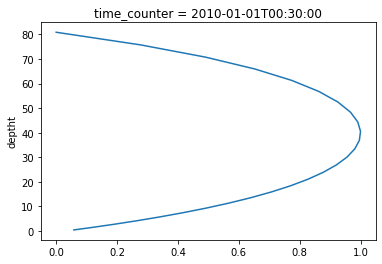

In [50]:
mu[:,0,0,0].plot(y='deptht')

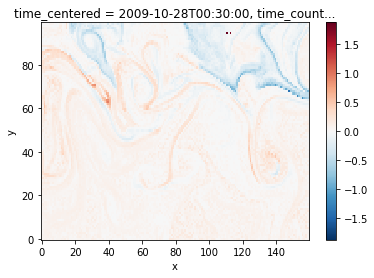

In [25]:
(t_b.isel(deptht=z10)-t_b[{'deptht':nMLD_b}])[0].plot()

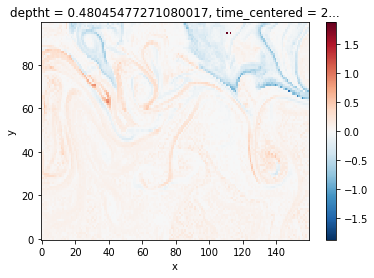

In [24]:
(t_b.isel(deptht=0)-t_b[{'deptht':nMLD_b}].data)[0].plot()

In [24]:
print(t_b.diff(dim='deptht')N2.shape)

(24, 73, 100, 160) (24, 73, 100, 160)


In [27]:
Bo_s = filt(Bo, area=At)
Bos_b = ((Bo_s*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                          boundary='trim').sum(skipna=True)
         / At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                       boundary='trim').sum(skipna=True)
        )
Bos_b

<xarray.DataArray (time_counter: 24, y: 100, x: 160)>
dask.array<truediv, shape=(24, 100, 160), dtype=float64, chunksize=(1, 100, 160), chunktype=numpy.ndarray>
Coordinates:
    deptht         float64 0.4805
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: y, x

In [53]:
pres = xr.apply_ufunc(gsw.p_from_z, -SA.deptht, SA.nav_lat[int(ncoars*.5+1)::ncoars,
                                                           int(ncoars*.5+1)::ncoars],
                      dask='parallelized', output_dtypes=[float,]
                     )
N2, pN2 = gsw.Nsquared(s_b, t_b, pres, SA.nav_lat[int(ncoars*.5+1)::ncoars,
                                                  int(ncoars*.5+1)::ncoars], axis=1)

In [20]:
# N2 = xr.DataArray(N2, dims=['time_counter','deptht','y','x'], 
#                   coords={'time_counter':dsW.time_counter.data,
#                           'deptht':dsW.depthw[1:].data}
#                  ).chunk({'deptht':-1}).interp(deptht=s_b.deptht)
# N2

<xarray.DataArray (time_counter: 24, deptht: 74, y: 100, x: 160)>
dask.array<transpose, shape=(24, 74, 100, 160), dtype=float64, chunksize=(24, 74, 100, 160), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-03-17T00:30:00 ... 2010-03-17T23:30:00
  * deptht        (deptht) float64 0.4805 1.559 2.794 ... 481.7 494.2 506.9
Dimensions without coordinates: y, x

In [24]:
bmx = (bm.isel(x=slice(1,None))
       + bm.isel(x=slice(None,-1)).data
      ) * .5
bmy = (bm.isel(y=slice(1,None))
       + bm.isel(y=slice(None,-1)).data
      ) * .5
dbmx = bmx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
dbmy = bmy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1
M2 = np.sqrt(dbmx.isel(y=slice(1,-1))**2 + dbmy.isel(x=slice(1,-1))**2)
print(M2)
dbmxH = (dbmx.isel(y=slice(1,-1)) 
         * xr.DataArray(e3t.isel(z=slice(len(dsT.deptht)),y=slice(1,-1),x=slice(1,-1)).data,
                        dims=['deptht','y','x'])
        ).where(dbmx.deptht <= MLD.isel(y=slice(1,-1),x=slice(1,-1))).sum('deptht',skipna=True)
dbmyH = (dbmy.isel(x=slice(1,-1)) 
         * xr.DataArray(e3t.isel(z=slice(len(dsT.deptht)),y=slice(1,-1),x=slice(1,-1)).data,
                        dims=['deptht','y','x'])
        ).where(dbmx.deptht <= MLD.isel(y=slice(1,-1),x=slice(1,-1))).sum('deptht',skipna=True)

dbmx_coar = ((dbmx.isel(y=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
dbmy_coar = ((dbmy.isel(x=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
M2_coar = ((M2*At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
           * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )

dbmx_coarH = (dbmx_coar 
         * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                        dims=['deptht','y','x'])
        ).where(dbmx_coar.deptht <= MLD_b).sum('deptht',skipna=True)
dbmy_coarH = (dbmy_coar 
         * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                        dims=['deptht','y','x'])
        ).where(dbmy_coar.deptht <= MLD_b).sum('deptht',skipna=True)
M2_coarH = (M2_coar 
            * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                           dims=['deptht','y','x'])
           ).where(dbmy_coar.deptht <= MLD_b).sum('deptht',skipna=True)

gradbm = np.sqrt(dbmx_coar**2 + dbmy_coar**2)
M2_coarH

<xarray.DataArray (deptht: 95, y: 500, x: 800)>
dask.array<sqrt, shape=(95, 500, 800), dtype=float64, chunksize=(1, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * deptht        (deptht) float64 0.4805 1.559 2.794 ... 774.7 790.2 805.8
    time_counter  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x


<xarray.DataArray (y: 100, x: 160)>
dask.array<sum-aggregate, shape=(100, 160), dtype=float64, chunksize=(100, 160), chunktype=numpy.ndarray>
Coordinates:
    time_counter   datetime64[ns] 2010-01-01T23:30:00
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

In [25]:
usx = (us.isel(x=slice(1,None))
       + us.isel(x=slice(None,-1)).data
      ) * .5
vsy = (vs.isel(y=slice(1,None))
       + vs.isel(y=slice(None,-1)).data
      ) * .5

us_coar = ((np.sqrt(usx.isel(y=slice(1,-1),x=slice(1,None))**2+vsy.isel(y=slice(1,None),x=slice(1,-1))**2)
            *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                          boundary='trim').sum(skipna=True)
           * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )
ws_coar = ((np.sqrt(ws**2).isel(y=slice(1,-1),x=slice(1,-1))
            *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                          boundary='trim').sum(skipna=True)
           * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )

us_coarH = (us_coar 
            * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                           dims=['deptht','y','x'])
           ).where(us_coar.deptht <= MLD_b).sum('deptht',skipna=True)
ws_coarH = (ws_coar 
            * xr.DataArray(e3w_b.isel(z=slice(len(dsW.depthw))).data,
                           dims=['depthw','y','x'])
           ).where(ws_coar.depthw <= MLD_b).sum('depthw',skipna=True)

us_coarH

<xarray.DataArray (y: 100, x: 160)>
dask.array<sum-aggregate, shape=(100, 160), dtype=float64, chunksize=(100, 160), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  datetime64[ns] 2010-01-01T23:30:00
    time_counter   datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

In [26]:
usx

<xarray.DataArray (deptht: 95, y: 502, x: 801)>
dask.array<mul, shape=(95, 502, 801), dtype=float64, chunksize=(1, 502, 801), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 0.4805 1.559 2.794 4.187 ... 774.7 790.2 805.8
Dimensions without coordinates: y, x

### $$\text{EBF} = \frac{{\bf \tau}}{\rho_0 f} \times \hat{\bf z} \cdot \nabla_\text{h}b_m = \frac{1}{\rho_0 f}(\tau^y {b_m}_x - \tau^x {b_m}_y)$$

In [33]:
EBF = (tauy.isel(y=slice(1,-1),x=slice(1,-1)) * dbmxH
       - taux.isel(y=slice(1,-1),x=slice(1,-1)) * dbmyH
      ) * (MLD*cori).isel(y=slice(1,-1),x=slice(1,-1))**-1*1e-3
EBF

<xarray.DataArray (time_counter: 24, y: 500, x: 800)>
dask.array<mul, shape=(24, 500, 800), dtype=float64, chunksize=(1, 500, 800), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
    nav_lat        (y, x) float32 36.69535 36.695553 ... 43.21733 43.217693
    nav_lon        (y, x) float32 -59.623344 -59.606667 ... -46.447792
Dimensions without coordinates: y, x

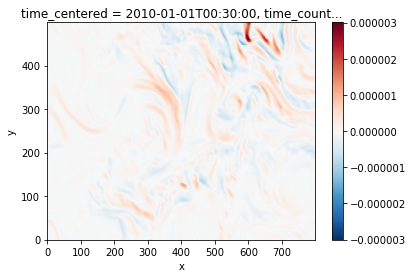

In [45]:
EBF[0].plot()

In [34]:
EBF_b = ((EBF*At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
         * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                        boundary='trim').sum(skipna=True)**-1
        )
EBF_b

<xarray.DataArray (time_counter: 24, y: 100, x: 160)>
dask.array<mul, shape=(24, 100, 160), dtype=float64, chunksize=(1, 100, 160), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
Dimensions without coordinates: y, x

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)
NoneType: None


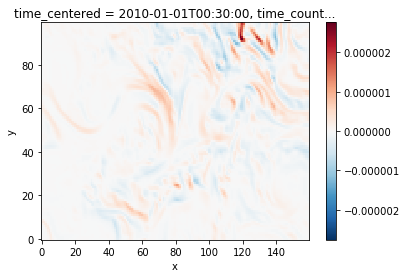

In [44]:
EBF_b[0].plot()

In [29]:
Ce = 0.01


# xu = dsmask.e1u.sel(y=slice(ys,ye),x=slice(xs,xe))[0]
# yv = dsmask.e2v.sel(y=slice(ys,ye),x=slice(xs,xe))[0]
# rAu = (dsmask.e1u * dsmask.e2u).sel(y=slice(ys,ye),x=slice(xs,xe))[0]
# rAv = (dsmask.e1v * dsmask.e2v).sel(y=slice(ys,ye),x=slice(xs,xe))[0]
# e1ub = ((e1u*Au).coarsen({'y':5,'x':5}, boundary='trim').sum()
#         / Au.coarsen({'y':5,'x':5}, boundary='trim').sum()
#        )
e1ub = e1u.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)
# e1vb = e1v.coarsen({'y':5,'x':5},boundary='trim').sum()
e1tb = e1t.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)
# e1vb = ((e1v*Av).coarsen({'y':5,'x':5}, boundary='trim').sum()
#         / Av.coarsen({'y':5,'x':5}, boundary='trim').sum()
#        )
# e2ub = ((e2u*Au).coarsen({'y':5,'x':5}, boundary='trim').sum()
#         / Au.coarsen({'y':5,'x':5}, boundary='trim').sum()
#        )
# e2vb = ((e2v*Av).coarsen({'y':5,'x':5}, boundary='trim').sum()
#         / Av.coarsen({'y':5,'x':5}, boundary='trim').sum()
#        )
# e2ub = e2u.coarsen({'y':5,'x':5},boundary='trim').sum()
e2vb = e2v.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)
e2tb = e2t.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)


Aub = Au.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
Avb = Av.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
# Atb = At.coarsen({'y':5,'x':5}, boundary='trim').sum()

# dbx = (b_b*e2tb).diff(dim='x', label='upper') * Aub[:,:-1]**-1
# dby = (b_b*e1tb).diff(dim='y', label='upper') * Avb[:-1]**-1
# dbz = xr.DataArray((b_b.diff(dim='deptht')
#                     * xr.DataArray(e3w[1:len(dsW.depthw)].data, dims=['deptht'])**-1).data, 
#                    dims=['time_counter','deptht','y','x'],
#                    coords={'time_counter':dsW.time_counter.data,'deptht':dsW.depthw[1:].data}
#                   ).chunk({'deptht':-1}).interp(deptht=dsT.deptht.data)
# dbx = (dbx.isel(x=slice(1,None))
#        + dbx.isel(x=slice(None,-1)).data
#       ) * .5
# dby = (dby.isel(y=slice(1,None)) 
#        + dby.isel(y=slice(None,-1)).data
#       ) * .5
bx = (b_b.isel(x=slice(1,None))
      + b_b.isel(x=slice(None,-1)).data
     ) * .5
by = (b_b.isel(y=slice(1,None))
      + b_b.isel(y=slice(None,-1)).data
     ) * .5
dbx = bx.diff(dim='x') * e1ub.isel(x=slice(1,-1))**-1
dby = by.diff(dim='y') * e2vb.isel(y=slice(1,-1))**-1
gradbb = np.sqrt(dbx.isel(y=slice(1,-1))**2 + dby.isel(x=slice(1,-1))**2)
        
# dbdtx = ((t_b*e2tb).diff(dim='x', label='upper')**-1 * (b_b*e2tb).diff(dim='x', label='upper'))
# dbdty = ((t_b*e1tb).diff(dim='y', label='upper')**-1 * (b_b*e1tb).diff(dim='y', label='upper'))
# dbdtz = xr.DataArray((t_b.diff(dim='deptht').data**-1
#                       * b_b.diff(dim='deptht').data), 
#                      dims=['time_counter','deptht','y','x'],
#                      coords={'time_counter':dsW.time_counter.data,'deptht':dsW.depthw[1:].data}
#                     ).chunk({'deptht':-1}).interp(deptht=dsT.deptht.data)
# dbdtzH = ((t_b*b_b).isel(deptht=0) - (tML*bML)
#          ) * MLD_b**-1
# dbdtz = dbdtz.where(np.abs(dbdtz)
#                     < np.abs(dbdtz).quantile(.98)).where(np.abs(dbdtz)
#                                                          > np.abs(dbdtz).quantile(.02))
# dbdtx = dbdtx.where(np.abs(dbdtx) < np.abs(dbdtx).quantile(.98)).where(np.abs(dbdtx) > np.abs(dbdtx).quantile(.02))
# dbdty = dbdty.where(np.abs(dbdty) < np.abs(dbdty).quantile(.98)).where(np.abs(dbdty) > np.abs(dbdty).quantile(.02))
# dtx = (t_b*e2tb).diff(dim='x', label='upper') * Aub[:,:-1]**-1
# dty = (t_b*e1tb).diff(dim='y', label='upper') * Avb[:-1]**-1
# dtx = (dtx.isel(x=slice(1,None))
#        + dtx.isel(x=slice(None,-1)).data
#       ) * .5
# dty = (dty.isel(y=slice(1,None)) 
#        + dty.isel(y=slice(None,-1)).data
#       ) * .5
# dbdtxH = (dbdtxH.isel(x=slice(1,None))
#           + dbdtxH.isel(x=slice(None,-1)).data
#          ) * .5
# dbdtyH = (dbdtyH.isel(y=slice(1,None)) 
#           + dbdtyH.isel(y=slice(None,-1)).data
#          ) * .5
        
# dbdsx = ((s_b*e2tb).diff(dim='x', label='upper')**-1 * (b_b*e2tb).diff(dim='x', label='upper'))
# dbdsy = ((s_b*e1tb).diff(dim='y', label='upper')**-1 * (b_b*e1tb).diff(dim='y', label='upper'))
# dbdsz = xr.DataArray((s_b.diff(dim='deptht').data**-1
#                       * b_b.diff(dim='deptht').data), 
#                      dims=['time_counter','deptht','y','x'],
#                      coords={'time_counter':dsW.time_counter.data,'deptht':dsW.depthw[1:].data}
#                     ).chunk({'deptht':-1}).interp(deptht=dsT.deptht.data)
# dbdtzH = ((s_b*b_b).isel(deptht=0) - (sML*bML)
#          ) * MLD_b**-1
# dbdsz = dbdsz.where(np.abs(dbdsz)
#                     < np.abs(dbdsz).quantile(.98)).where(np.abs(dbdsz)
#                                                          > np.abs(dbdsz).quantile(.02))
# dbdsx = dbdsx.where(np.abs(dbdsx) < np.abs(dbdsx).quantile(.98)).where(np.abs(dbdsx) > np.abs(dbdsx).quantile(.02))
# dbdsy = dbdsy.where(np.abs(dbdsy) < np.abs(dbdsy).quantile(.98)).where(np.abs(dbdsy) > np.abs(dbdsy).quantile(.02))
# dsx = (s_b*e2tb).diff(dim='x', label='upper') * Aub[:,:-1]**-1
# dsy = (s_b*e1tb).diff(dim='y', label='upper') * Avb[:-1]**-1
# dsx = (dsx.isel(x=slice(1,None))
#        + dsx.isel(x=slice(None,-1)).data
#       ) * .5
# dsy = (dsy.isel(y=slice(1,None)) 
#        + dsy.isel(y=slice(None,-1)).data
#       ) * .5
# dbdsxH = (dbdsxH.isel(x=slice(1,None))
#           + dbdsxH.isel(x=slice(None,-1)).data
#          ) * .5
# dbdsyH = (dbdsyH.isel(y=slice(1,None)) 
#           + dbdsyH.isel(y=slice(None,-1)).data
#          ) * .5
        
# print(dty, dby, dtx, dbx)    
# dbxH = ((dbx * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#         ).where(dbx.deptht <= MLD_b.isel(x=slice(1,-1))).sum('deptht') 
#         )
# dbyH = ((dby * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#         ).where(dby.deptht <= MLD_b.isel(y=slice(1,-1))).sum('deptht') 
#         )
dbxH = (dbx * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(x=slice(1,-1)).data,
                           dims=['deptht','y','x'])
       ).where(dbx.deptht <= MLD_b.isel(x=slice(1,-1))
              ).sum('deptht',skipna=True)
dbyH = (dby * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(y=slice(1,-1)).data,
                           dims=['deptht','y','x'])
       ).where(dby.deptht <= MLD_b.isel(y=slice(1,-1))
              ).sum('deptht',skipna=True)
# dtxH = ((dtx * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#         ).where(dtx.deptht <= MLD_b.isel(x=slice(1,-1))).sum('deptht') 
#         )
# dtyH = ((dty * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#         ).where(dty.deptht <= MLD_b.isel(y=slice(1,-1))).sum('deptht') 
#         )
# dsxH = ((dsx * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#         ).where(dsx.deptht <= MLD_b.isel(x=slice(1,-1))).sum('deptht') 
#         )
# dsyH = ((dsy * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#         ).where(dsy.deptht <= MLD_b.isel(y=slice(1,-1))).sum('deptht') 
#         )
# dtzH = (t_b.isel(deptht=0) - tML) 
# dszH = (s_b.isel(deptht=0) - sML) 
# dbzH = (b_b.isel(deptht=0) - bML) 

# dbdt = (dbdtz.isel(y=slice(1,-1),x=slice(1,-1)) 
#         + dbdty.isel(x=slice(1,-1)) 
#         + dbdtx.isel(y=slice(1,-1)))
# dbds = (dbdsz.isel(y=slice(1,-1),x=slice(1,-1)) 
#         + dbdsy.isel(x=slice(1,-1)) 
#         + dbdsx.isel(y=slice(1,-1)))
# dbdtH = (dbdtzH.isel(y=slice(1,-1),x=slice(1,-1)) 
#         + dbdtyH.isel(x=slice(1,-1)) 
#         + dbdtxH.isel(y=slice(1,-1)))
# dbdsH = (dbdszH.isel(y=slice(1,-1),x=slice(1,-1)) 
#         + dbdsyH.isel(x=slice(1,-1)) 
#         + dbdsxH.isel(y=slice(1,-1)))
# dtdbH = ((dbdt * xr.DataArray(e3t.data[:len(t_b.deptht)],dims=['deptht'])
#          ).where(dbdt.deptht <= MLD_b.isel(y=slice(1,-1),x=slice(1,-1))).sum('deptht') 
#          * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1)**-1
# dsdbH = ((dbds * xr.DataArray(e3t.data[:len(s_b.deptht)],dims=['deptht'])
#          ).where(dbds.deptht <= MLD_b.isel(y=slice(1,-1),x=slice(1,-1))).sum('deptht') 
#          * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1)**-1
# dtdbH = ((dtzH * dbzH**-1).isel(y=slice(1,-1),x=slice(1,-1))
#          + (dtyH * dbyH**-1).isel(x=slice(1,-1)) 
#          + (dtxH * dbxH**-1).isel(y=slice(1,-1)))
# dsdbH = ((dszH * dbzH**-1).isel(y=slice(1,-1),x=slice(1,-1))
#          + (dsyH * dbyH**-1).isel(x=slice(1,-1)) 
#          + (dsxH * dbxH**-1).isel(y=slice(1,-1)))
gradbb

<xarray.DataArray (deptht: 95, y: 98, x: 158)>
dask.array<sqrt, shape=(95, 98, 158), dtype=float64, chunksize=(95, 98, 158), chunktype=numpy.ndarray>
Coordinates:
  * deptht        (deptht) float64 0.4805 1.559 2.794 ... 774.7 790.2 805.8
    time_counter  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

Text(0.5, 1.0, '$\\partial_y \\langle b \\rangle$')

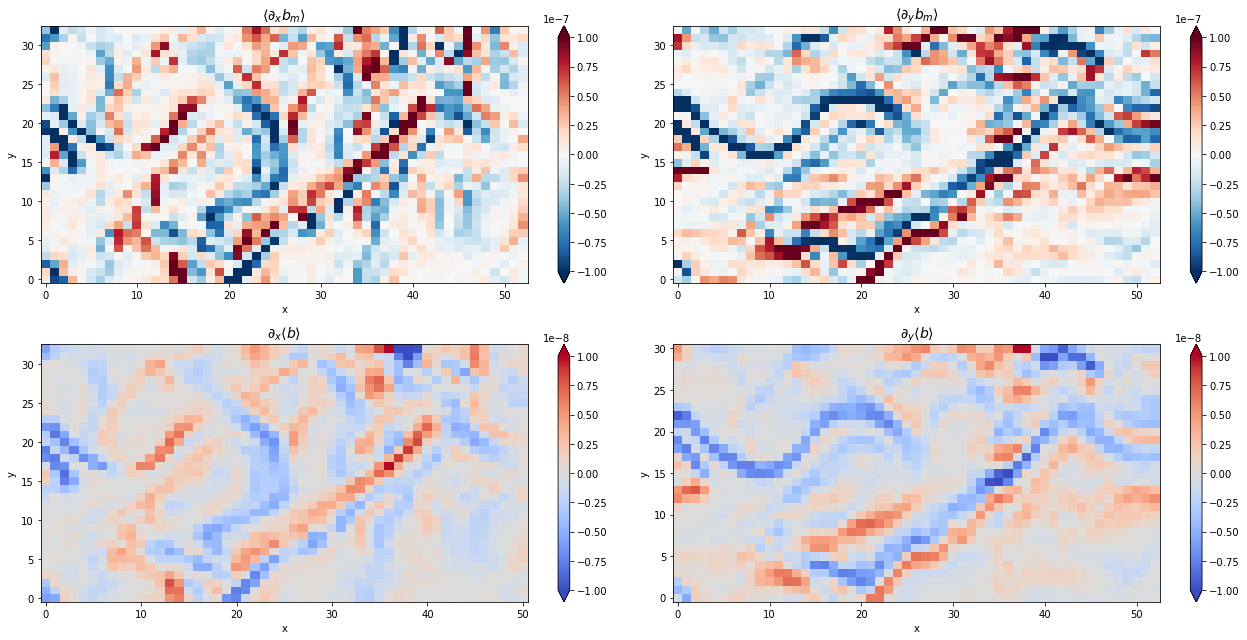

In [36]:
fig, axes = plt.subplots(figsize=(18,9), nrows=2, ncols=2)
fig.set_tight_layout(True)

(dbmx_coar[0,20]).plot(ax=axes[0,0], vmax=1e-7, cmap='RdBu_r', rasterized=True)
(dbmy_coar[0,20]).plot(ax=axes[0,1], vmax=1e-7, cmap='RdBu_r', rasterized=True)
(dbx[0,20]).plot(ax=axes[1,0], vmax=1e-8, cmap='coolwarm', rasterized=True)
(dby[0,20]).plot(ax=axes[1,1], vmax=1e-8, cmap='coolwarm', rasterized=True)

axes[0,0].set_title(r"$\langle \partial_x b_m \rangle$", fontsize=14)
axes[0,1].set_title(r"$\langle \partial_y b_m \rangle$", fontsize=14)
axes[1,0].set_title(r"$\partial_x \langle b \rangle$", fontsize=14)
axes[1,1].set_title(r"$\partial_y \langle b \rangle$", fontsize=14)

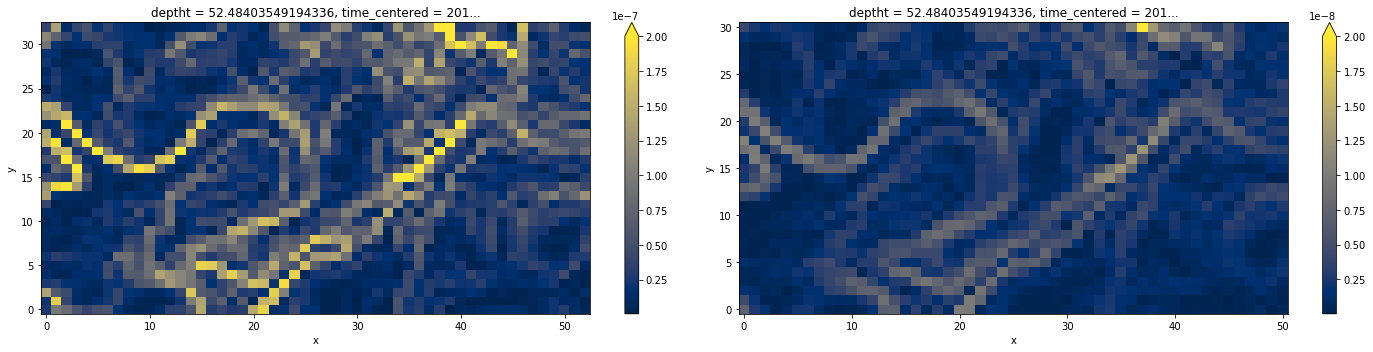

In [34]:
fig, (ax1,ax2) = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(gradbm[0,20]).plot(ax=ax1, vmax=2e-7, cmap='cividis')
(gradbb[0,20]).plot(ax=ax2, vmax=2e-8, cmap='cividis')

In [60]:
psibb = (wsbs_b.isel(y=slice(1,-1),x=slice(1,-1)) 
         * (.5*(gradbb.isel(deptht=slice(None,-1)).data
                + gradbb.isel(deptht=slice(1,None)).data))**-1
        )
psibm = (wsbs_b * (.5*(gradbm.isel(deptht=slice(None,-1)).data
                       + gradbm.isel(deptht=slice(1,None)).data))**-1
        )
psibb

<xarray.DataArray (time_counter: 24, depthw: 94, y: 98, x: 158)>
dask.array<mul, shape=(24, 94, 98, 158), dtype=float64, chunksize=(1, 1, 98, 158), chunktype=numpy.ndarray>
Coordinates:
  * depthw         (depthw) float64 1.0 2.157 3.471 4.943 ... 767.1 782.4 798.0
    nav_lat        (y, x) float32 dask.array<chunksize=(98, 158), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(98, 158), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: y, x

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)": []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)
NoneType: None


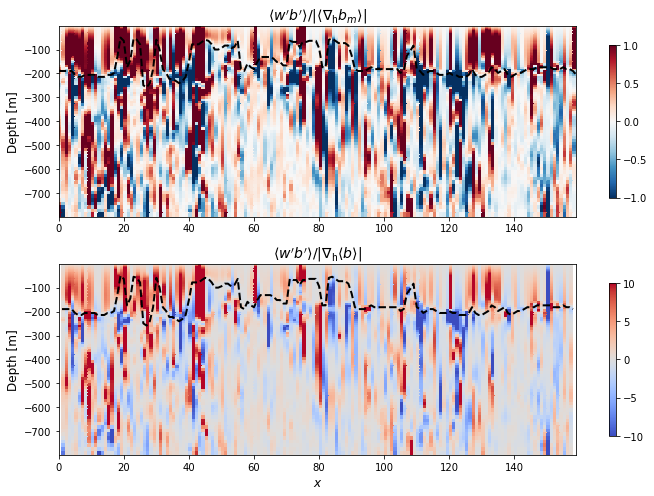

In [61]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,7), nrows=2, ncols=1)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(psibm.x, -psibm.depthw, psibm.isel(time_counter=-1,y=20), 
                     rasterized=True, vmax=1., vmin=-1., cmap='RdBu_r')
im2 = ax2.pcolormesh(np.arange(1,len(psibb.x)+1), -psibb.depthw, psibb.isel(time_counter=-1,y=19), 
                     rasterized=True, vmax=1e1, vmin=-1e1, cmap='coolwarm')
ax1.plot(MLD_b.x, -MLD_b.isel(time_counter=-1,y=20), 'k--', lw=2)
ax2.plot(np.arange(1,len(MLD_b.x)-1), 
         -MLD_b.isel(time_counter=-1,y=20,x=slice(1,-1)), 'k--', lw=2)

ax1.set_xlim([0,len(psibm.x)-1])
ax2.set_xlim([0,len(psibm.x)-1])
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_xlabel(r"$x$", fontsize=12)

# fig.subplots_adjust(right=0.86, hspace=.24)
# cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
# cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
fig.colorbar(im1, ax=ax1, shrink=.8)
fig.colorbar(im2, ax=ax2, shrink=.8)

ax1.set_title(r"$\langle w'b'\rangle / |\langle\nabla_{\tt h}b_m\rangle|$",
              fontsize=14)
ax2.set_title(r"$\langle w'b'\rangle / |\nabla_{\tt h}\langle b\rangle|$",
              fontsize=14)

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/psi_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
            % ncoars)

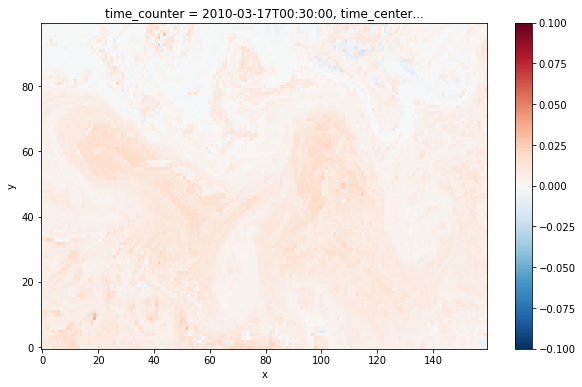

In [75]:
(dbdtz * xr.DataArray(e3t.data[:len(t_b.deptht)],dims=['deptht'])
 ).where(dbdtz.deptht <= MLD_b).mean('deptht', skipna=True)[0].plot(figsize=(10,6), vmax=1e-1)

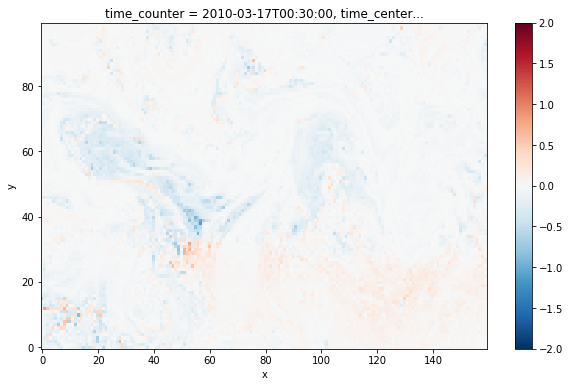

In [76]:
(dbdsz * xr.DataArray(e3t.data[:len(s_b.deptht)],dims=['deptht'])
 ).where(dbdsz.deptht <= MLD_b).mean('deptht')[0].plot(figsize=(10,6), vmax=2e0)

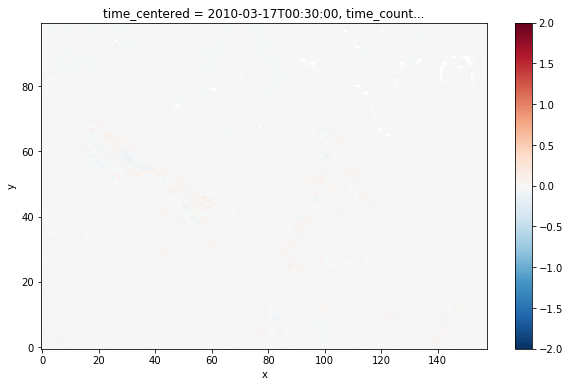

In [77]:
(dbdtx * xr.DataArray(e3t.data[:len(t_b.deptht)],dims=['deptht'])
 ).where(dbdtx.deptht <= MLD_b.isel(x=slice(1,-1))).mean('deptht')[0].plot(figsize=(10,6), vmax=2e0)

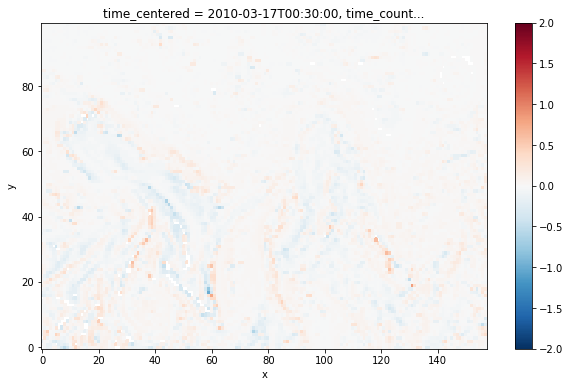

In [82]:
(dbdsx * xr.DataArray(e3t.data[:len(s_b.deptht)],dims=['deptht'])
 ).where(dbdsx.deptht <= MLD_b.isel(x=slice(1,-1))).mean('deptht', skipna=True)[0].plot(figsize=(10,6), vmax=2e0)

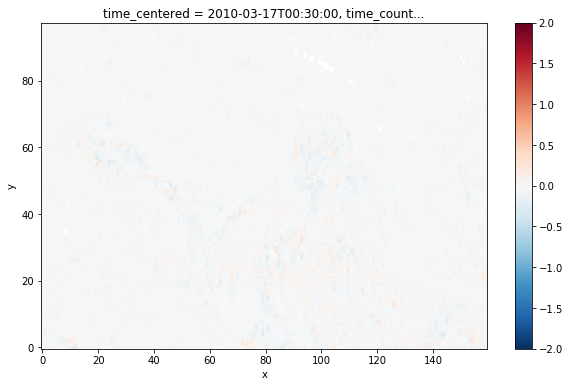

In [79]:
(dbdty * xr.DataArray(e3t.data[:len(t_b.deptht)],dims=['deptht'])
 ).where(dbdty.deptht <= MLD_b.isel(y=slice(1,-1))).mean('deptht')[0].plot(figsize=(10,6), vmax=2e0)

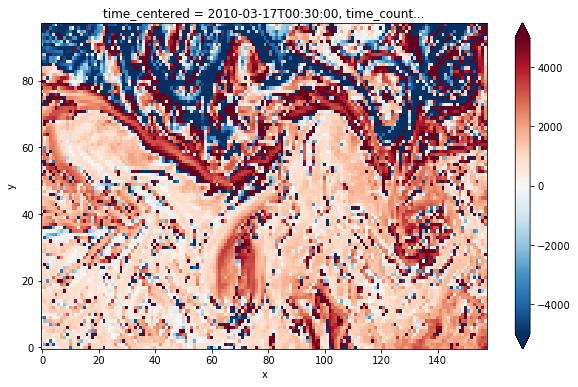

In [18]:
(dtdbH)[0].plot(vmax=5e3, figsize=(10,6))

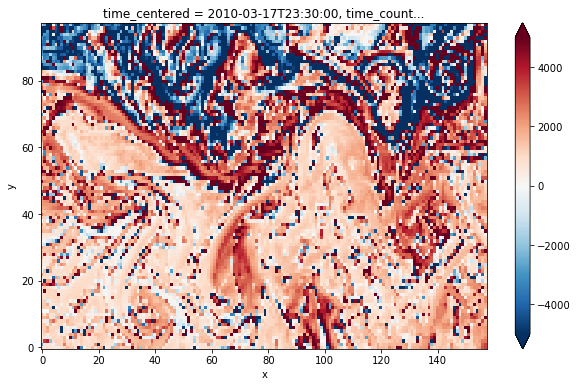

In [19]:
(dtdbH)[-1].plot(vmax=5e3, figsize=(10,6))

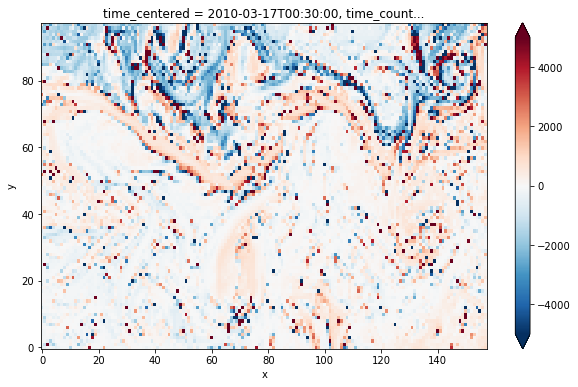

In [20]:
(dsdbH)[0].plot(vmax=5e3, figsize=(10,6))

In [30]:
lat_b = ((dsmask.nav_lat.isel(y=slice(ys+1,ye-1),x=slice(xs+1,xe-1))
          * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
         * Atb**-1
        )
p = xr.apply_ufunc(gsw.p_from_z, 
                   xr.DataArray(-e3w_b.isel(z=slice(None,len(dsT.deptht))).cumsum('z').data, 
                                dims=['deptht','y','x'],
                                coords={'deptht':dsT.deptht.data,
#                                         'time_counter':dsT.time_counter.data
                                       }), 
                   lat_b,
                   dask='parallelized', output_dtypes=['float',]
                  ).transpose('deptht','y','x')
N2, pN2 = gsw.Nsquared(s_b[-1], t_b[-1], p, lat_b, axis=0)
N2 = xr.DataArray(N2.data, dims=['depthw','y','x'], 
                  coords={
#                           'time_counter':dsW.time_counter.data,
                          'depthw':dsW.depthw[1:].data})
N = (np.sqrt(N2) * xr.DataArray(e3w_b.isel(z=slice(1,len(N2.depthw)+1)),
                                dims=['depthw','y','x'])
    ).where(N2.depthw <= MLD_b).sum('depthw') * MLD_b**-1

In [31]:
p = xr.apply_ufunc(gsw.p_from_z, 
                   xr.DataArray(-e3w.isel(z=slice(None,len(dsT.deptht))).cumsum('z').data, 
                                dims=['deptht','y','x'],
                                coords={'deptht':dsT.deptht.data}), 
                   dsT.nav_lat.isel(y=slice(ys,ye),x=slice(xs,xe)),
                   dask='parallelized', output_dtypes=['float',]
                  ).transpose('deptht','y','x')
N2m, pN2 = gsw.Nsquared(sm[-1], tm[-1], p, dsT.nav_lat.isel(y=slice(ys,ye),x=slice(xs,xe)), axis=0)
N2m = xr.DataArray(N2m.data, dims=['depthw','y','x'], 
                   coords={'depthw':dsW.depthw[1:].data})

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  import sys


In [32]:
N2_coar = ((N2m.sel(y=slice(1,-1),x=slice(1,-1))
            *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                          boundary='trim').sum(skipna=True)
           * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )

N2_coarH = (N2_coar 
            * xr.DataArray(e3w_b.isel(z=slice(1,len(dsW.depthw))).data,
                           dims=['depthw','y','x'])
           ).where(N2_coar.depthw <= MLD_b).sum('depthw',skipna=True)

In [33]:
gradBb2 = dbxH.isel(y=slice(1,-1))**2 + dbyH.isel(x=slice(1,-1))**2
# dtdz = -t_b.diff('deptht').sum('deptht') * MLD_b**-1
gradbb2H = (Ce 
            * gradBb2  
            * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
           )

gradBm2 = dbmx_coarH**2 + dbmy_coarH**2
# dtdz = -t_b.diff('deptht').sum('deptht') * MLD_b**-1
gradbm2H = (Ce 
            * gradBm2  
            * np.abs(fb)**-1
           )
BacH = Ce * (M2_coarH*us_coarH
             + N2_coarH*ws_coarH
            ) * M2_coarH
# gradtb2H = ((Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
#              * (gradB2 * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**2) 
#              * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
#              * xr.DataArray(e3t[:len(t_b.deptht)], dims='deptht',
#                             coords={'deptht':t_b.deptht.data}
#                            )
#             ).sum('deptht') 
#             * (MLD_b**-1 * N2bar**-1 * dtdz).isel(y=slice(1,-1),x=slice(1,-1))
#            ).compute()
# gradtb2H = (-alpha*g * mu.isel(y=slice(1,-1),x=slice(1,-1))
#             * (gradT2 * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**2) 
#             * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
#             * xr.DataArray(e3t[:len(t_b.deptht)], dims='deptht',
#                            coords={'deptht':t_b.deptht.data}
#                           )
#            ).sum('deptht') * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1


# Omdt_bar = (gradbb2H 
# #             * ((N2 * xr.DataArray(e3w[1:len(dsW.depthw)], dims='depthw',
# #                                   coords={'depthw':dsW.depthw[1:].data}
# #                                  )).sum('depthw')**-1 
# #                        ).isel(y=slice(1,-1),x=slice(1,-1))
#             * dtdbH 
#             * (mu.isel(y=slice(1,-1),x=slice(1,-1)) 
#                * xr.DataArray(e3t[:len(dsT.deptht)], dims='deptht',
#                               coords={'deptht':dsT.deptht.data}
#                              )
#               ).sum('deptht') * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1
#            ).compute()
BacH

<xarray.DataArray (y: 100, x: 160)>
dask.array<mul, shape=(100, 160), dtype=float64, chunksize=(100, 160), chunktype=numpy.ndarray>
Coordinates:
    time_counter   datetime64[ns] 2010-01-01T23:30:00
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

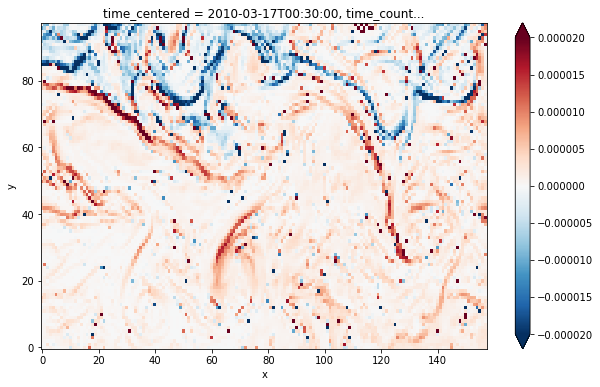

In [35]:
Omdt_bar[0].plot(vmax=2e-5, figsize=(10,6))

In [34]:
lamML = (N*MLD_b*fb**-1).compute()
lamML_b = (np.sqrt(gradBb2) * fb.isel(y=slice(1,-1),x=slice(1,-1))**-2).compute()
lamML_m = (np.sqrt(gradBm2) * fb**-2).compute()

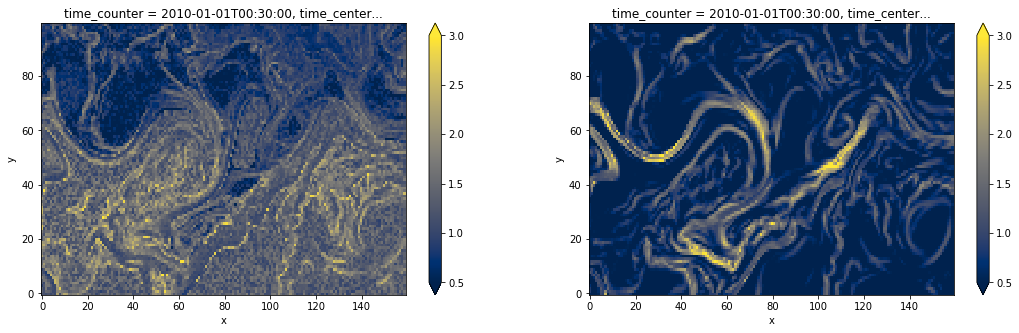

In [70]:
fig, (ax1,ax2) = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
(lamML[0]*1e-3).plot(ax=ax1, vmax=3., vmin=.5, cmap='cividis')
(lamML_m[0]*1e-3).plot(ax=ax2, vmax=3., vmin=.5, cmap='cividis')

In [35]:
boostb = (np.sqrt(Atb.isel(y=slice(1,-1),x=slice(1,-1))) 
          * np.maximum(np.maximum(lamML.isel(y=slice(1,-1),x=slice(1,-1)), 
                                  lamML_b),
                       1e3)**-1)
boostm = (np.sqrt(Atb) 
          * np.maximum(np.maximum(lamML, 
                                  lamML_m),
                       1e3)**-1)
boostm

<xarray.DataArray (y: 100, x: 160)>
array([[6.90305438, 7.33422629, 7.33501428, ..., 7.42226746, 7.42283309,
        7.42334726],
       [6.65049858, 7.32750034, 7.32826673, ..., 7.41608282, 7.41663246,
        7.41713921],
       [7.3202632 , 7.32083402, 7.32153922, ..., 7.4099407 , 7.41044548,
        7.41092919],
       ...,
       [6.68247106, 6.68320678, 6.68441317, ..., 6.82219029, 6.82304937,
        6.82384568],
       [6.67589204, 6.67679448, 6.67789808, ..., 6.81621975, 6.81700207,
        6.81776063],
       [6.66932689, 6.67000242, 6.26793409, ..., 6.80997291, 6.8108695 ,
        6.81168721]])
Coordinates:
    nav_lat        (y, x) float32 36.721783 36.722797 ... 43.190693 43.1925
    nav_lon        (y, x) float32 -59.590477 -59.50708 ... -46.564472 -46.480423
    time_centered  datetime64[ns] 2010-01-01T23:30:00
    time_counter   datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

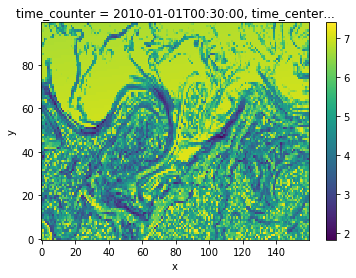

In [72]:
boostm[:,:,0].plot()

ValueError: arguments without labels along dimension 'y' cannot be aligned because they have different dimension sizes: {33, 31}

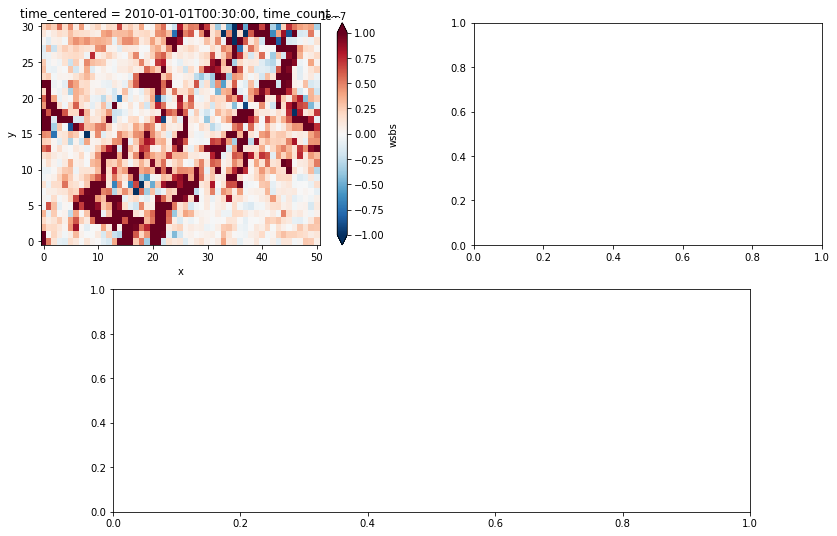

In [44]:
gradbb2H.name = 'BFK'
wsbsb_ML.name = 'wsbs'
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14,9))
# fig.set_tight_layout(True)
gs = GridSpec(2,11,figure=fig)
ax1 = fig.add_subplot(gs[0,:5])
ax2 = fig.add_subplot(gs[0,6:])
ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML[0,1:-1,1:-1].plot(ax=ax1, vmax=1e-7, cmap='RdBu_r', rasterized=True)
(.1*(gradbb2H * (mu.isel(y=slice(1,-1),x=slice(1,-1)) 
                 * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                dims=['deptht','y','x','time_counter'],
                                coords={'deptht':dsT.deptht.data,
                                        'time_counter':dsT.time_counter.data}
                               )
                ).sum('deptht') 
     * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1)[0]).plot(ax=ax2, vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)
xhist(.1*(gradbb2H * (mu.isel(y=slice(1,-1),x=slice(1,-1)) 
                      * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                     dims=['deptht','y','x','time_counter'],
                                     coords={'deptht':dsT.deptht.data,
                                             'time_counter':dsT.time_counter.data}
                                    )
                     ).sum('deptht') 
          * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1).chunk({'time_counter':1}), 
      wsbsb_ML[:,1:-1,1:-1].chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$ [m$^2$ s$^{-3}$]", fontsize=14)
ax2.set_title(r"$H_{\tt ML}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2 f^{-1}$"
               + r"($\times 10^{-3}$)", 
               fontsize=14)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$ [m$^2$ s$^{-3}$]", fontsize=15)
ax3.set_ylabel(r"$\frac{H_{\tt ML}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2}{f}$"
              + r"($\times 10^{-3}$) [m$^2$ s$^{-3}$]", 
             fontsize=15)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_%01d_Jan-01-2010_GulfStreamPatch.pdf' 
            % ncoars)

$$\overline{\langle w^sb^s\rangle}^z \approx \frac{H^2 |\overline{\langle \nabla b^m\rangle}^z|^2}{f}$$

or 

$$H\Big(\overline{\langle\sqrt{|{\bf u}^s|^2} \rangle}^z M^2 + 2\overline{\langle \sqrt{{w^s}^2} \rangle}^z N^2\Big) |\overline{\langle \nabla b^m\rangle}^z|$$

In [37]:
BFK = gradbm2H * ((mu
                                         * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                        dims=['deptht','y','x'],
                                                        coords={'deptht':dsT.deptht.data,
#                                             'time_counter':dsT.time_counter.data
                                                       }
                                   ) 
                                        ).sum('deptht') 
                                        * MLD_b**-1
                                       ) * boostm
Bach = BacH * ((mu
                * xr.DataArray(e3t_b.isel(z=slice(None,len(dsT.deptht))), 
                               dims=['deptht','y','x'],
                               coords={'deptht':dsT.deptht.data,
#                                             'time_counter':dsT.time_counter.data
                                      }
                              ) 
               ).sum('deptht') 
               * MLD_b**-1
              ) * boostm

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:53092 remote=tcp://127.0.0.1:45442>
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-d7e8bd5bed27a21215d667d1082d5ddb', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d7e8bd5bed27a21215d667d1082d5ddb', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-d7e8bd5bed27a21215d667d1082d5ddb', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d7e8bd5bed27a21215d667d1082d5ddb', 0, 0, 0)
NoneType: None


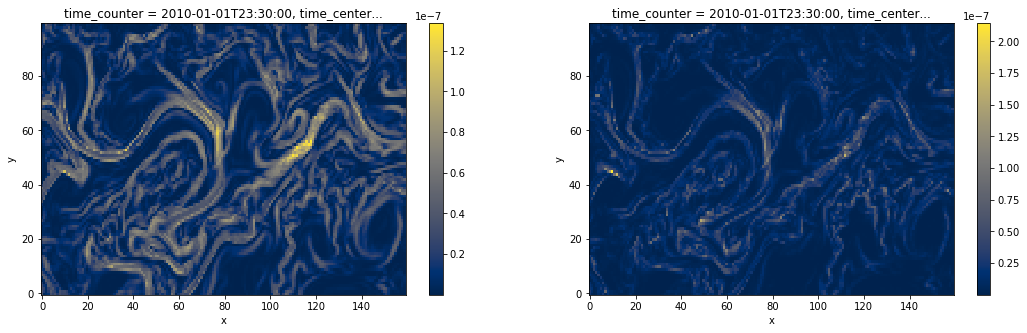

In [39]:
fig, (ax1,ax2) = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
(BFK).plot(ax=ax1, cmap='cividis')
(1e3*Bach).plot(ax=ax2, cmap='cividis')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:53260 remote=tcp://127.0.0.1:45442>
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-be55ca36cc81dc381c75764940ffc6ac', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-be55ca36cc81dc381c75764940ffc6ac', 0, 0, 0)
NoneType: None


Text(0, 0.5, '$\\frac{\\Delta s}{L_f}\\frac{H_{\\tt ML}^2|\\overline{\\langle\\nabla_{\\tt h} b_m\\rangle}^z|^2}{f}$$\\overline{\\mu}^z\\ \\ (\\times 10^{-2})$')

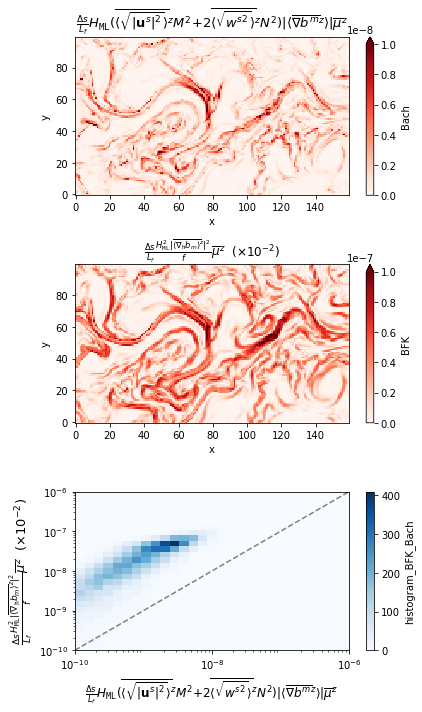

In [40]:
BFK.name = 'BFK'
Bach.name = 'Bach'

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
(1e2*Bach).plot(ax=ax1, vmin=0., vmax=1e-8, cmap='Reds', rasterized=True)
(BFK).plot(ax=ax2, vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)
xhist(BFK, 
      1e2*Bach,
      bins=[np.logspace(-10,-6,30), np.logspace(-10,-6,30)]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
# ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([1e-10,1e-6])
ax3.set_xticks([1e-10,1e-8,1e-6])
ax3.set_xlabel(r"$\frac{\Delta s}{L_f}H_{\tt ML} (\overline{\langle\sqrt{|{\bf u}^s|^2} \rangle}^z M^2$"
               +r"$+ 2\overline{\langle \sqrt{{w^s}^2} \rangle}^z N^2) |\langle \overline{\nabla b^m}^z\rangle|$"
               + r"$\overline{\mu}^z$", fontsize=12)
ax2.set_title(r"$\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\langle\nabla_{\tt h} b_m\rangle}^z|^2}{f}$"
              + r"$\overline{\mu}^z\ \ (\times 10^{-2})$",
              fontsize=12)
ax1.set_title(r"$\frac{\Delta s}{L_f}H_{\tt ML} (\overline{\langle\sqrt{|{\bf u}^s|^2} \rangle}^z M^2$"
               +r"$+ 2\overline{\langle \sqrt{{w^s}^2} \rangle}^z N^2) |\langle \overline{\nabla b^m}^z\rangle|$"
               + r"$\overline{\mu}^z$", fontsize=13)
ax3.set_ylabel(r"$\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\langle\nabla_{\tt h} b_m\rangle}^z|^2}{f}$"
               + r"$\overline{\mu}^z\ \ (\times 10^{-2})$", 
              fontsize=13)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
# plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_BFKmeso_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
#             % ncoars)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55604 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55606 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55608 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55610 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55612 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55614 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55616 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55618 remote=tcp://127.0.0.1:45640>
distribu

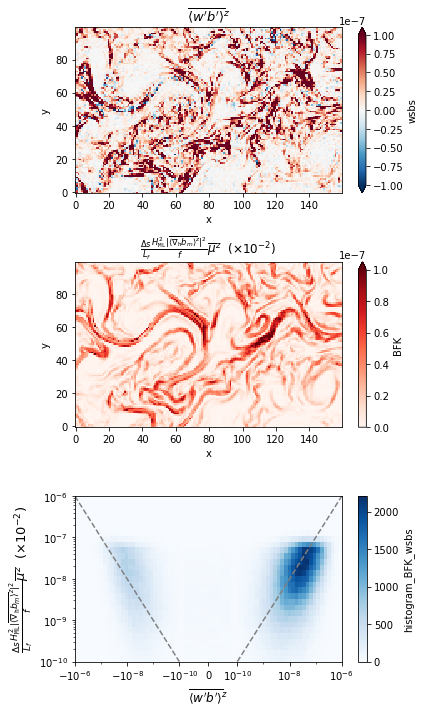

In [73]:
param.name = 'BFK'
wsbsb_ML.name = 'wsbs'

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML[-1].plot(ax=ax1, vmax=1e-7, cmap='RdBu_r', rasterized=True)
(param[-1]).plot(ax=ax2, vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)
xhist(param.chunk({'time_counter':1}), 
      wsbsb_ML[:].chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xticks([-1e-6,-1e-8,-1e-10,0,1e-10,1e-8,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=12)
ax2.set_title(r"$\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\langle\nabla_{\tt h} b_m\rangle}^z|^2}{f}$"
              + r"$\overline{\mu}^z\ \ (\times 10^{-2})$",
              fontsize=12)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=13)
ax3.set_ylabel(r"$\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\langle\nabla_{\tt h} b_m\rangle}^z|^2}{f}$"
               + r"$\overline{\mu}^z\ \ (\times 10^{-2})$", 
              fontsize=13)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_BFKmeso_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
            % ncoars)

$$\overline{w'b'} = c_e \text{BFK} + \delta B_{0_s} + \gamma \text{EBF}$$
$$
\left(\begin{array}{c} 
\vdots \\
\overline{w'b'}^{ji} \\
\vdots
\end{array}\right) 
=
\left(\begin{array}{ccc}
\vdots & \vdots & \vdots \\
\text{BFK}^{ji} & B_{0_s}^{ji} & \text{EBF} \\
\vdots & \vdots & \vdots
\end{array}\right)
\cdot 
\left(\begin{array}{c} 
c_e \\
\delta \\
\gamma
\end{array}\right)
$$

In [42]:
Nt,Ny,Nx = param[::6].shape
consts_EBF = xr.DataArray(np.ones((Nt,2))*np.nan, dims=['time_counter','coeffs'],
                          coords={'time_counter':param.time_counter[::6].data})
consts_Bo = xr.DataArray(np.ones((Nt,2))*np.nan, dims=['time_counter','coeffs'],
                         coords={'time_counter':param.time_counter[::6].data})
consts_tot = xr.DataArray(np.ones((Nt,3))*np.nan, dims=['time_counter','coeffs'],
                          coords={'time_counter':param.time_counter[::6].data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

for tt in wsbsb_ML.time_counter[::6]:
    bfk = np.ma.masked_invalid(param.sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_ML.sel(time_counter=tt))
    bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    
    bo = np.ma.masked_array(np.ma.masked_array(Bos_b.sel(time_counter=tt),bfk.mask),
                            wb.mask).compressed()
    ebf = np.ma.masked_array(np.ma.masked_array(EBF_b.sel(time_counter=tt),bfk.mask),
                             wb.mask).compressed()
    
    
    rhs = np.append(bfk_comp.reshape((len(bfk_comp),1)), ebf.reshape((len(bfk_comp),1)), axis=1)
    
    consts_EBF.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(rhs),wb_comp).ravel()
    
    rhs = np.append(bfk_comp.reshape((len(bfk_comp),1)), bo.reshape((len(bfk_comp),1)), axis=1)
    
    consts_Bo.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(rhs),wb_comp).ravel()
    
    rhs = np.append(np.append(bfk_comp.reshape((len(bfk_comp),1)), bo.reshape((len(bfk_comp),1)), axis=1),
                    ebf.reshape((len(bfk_comp),1)), axis=1)
    consts_tot.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(rhs),wb_comp).ravel()
#     cep.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bfk),wb).ravel()
#     print(tt)
consts_tot

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)": []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef24

<xarray.DataArray (time_counter: 4, coeffs: 3)>
array([[ 1.06460988, -0.00851407,  0.00612409],
       [ 0.97831062, -0.00805485,  0.02897186],
       [ 1.05697452, -0.00386461,  0.01400623],
       [ 1.04528265, -0.0044092 ,  0.01328013]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T18:30:00
Dimensions without coordinates: coeffs

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-21b4b0f9ca3ecef2422b1ed17fc082ee', 0, 0, 0, 0)
NoneType: None


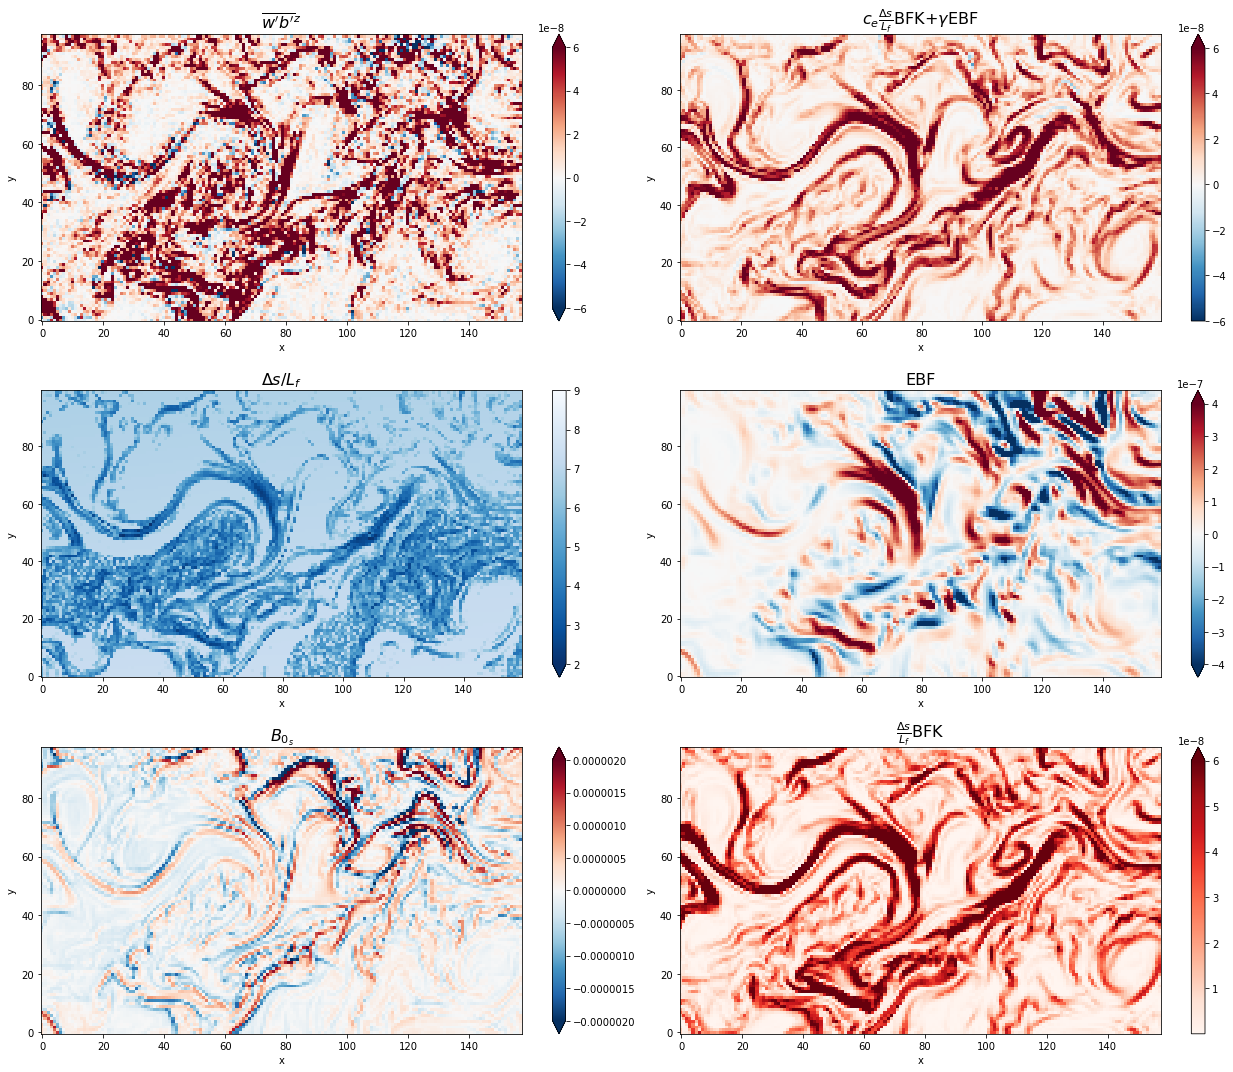

In [43]:
itime = 3
fig, axes = plt.subplots(figsize=(18,15), nrows=3, ncols=2)
fig.set_tight_layout(True)


wsbsb_ML.isel(time_counter=itime, y=slice(1,-1), x=slice(1,-1)).plot(ax=axes[0,0], vmax=6e-8, rasterized=True)

(param.isel(y=slice(1,-1),x=slice(1,-1))
).isel(time_counter=itime).plot(ax=axes[2,1], vmax=6e-8, cmap='Reds', rasterized=True)

EBF_b.isel(time_counter=itime).plot(ax=axes[1,1], vmax=4e-7, cmap='RdBu_r', rasterized=True)

boostm.isel(time_counter=itime).plot(ax=axes[1,0], cmap='Blues_r', rasterized=True,
                                     vmin=2, vmax=9)

Bos_b.isel(time_counter=itime).isel(y=slice(1,-1), x=slice(1,-1)).plot(ax=axes[2,0], vmax=2e-6, rasterized=True)
# Bot_b.sel(time_counter='2010-01-01')[-1].isel(y=slice(1,-1),
#                                               x=slice(1,-1)).plot(ax=axes[2,1], vmax=5e-5, rasterized=True)
# (consts_EBF[:,0]*param + consts_EBF[:,-1]*EBF_b
# ).isel(time_counter=itime).plot(ax=axes[0,1], vmax=6e-8, cmap='RdBu_r', rasterized=True)
(consts_tot[:,0]*param + consts_tot[:,1]*Bos_b + consts_tot[:,-1]*EBF_b
).isel(time_counter=itime).plot(ax=axes[0,1], vmax=6e-8, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$\overline{w'b'}^z$", fontsize=16)
axes[1,1].set_title(r"EBF", fontsize=16)
axes[2,1].set_title(r"$\frac{\Delta s}{L_f}$BFK", fontsize=16)
axes[1,0].set_title(r"$\Delta s / L_f$", fontsize=16)
axes[2,0].set_title(r"$B_{0_s}$", fontsize=16)
axes[0,1].set_title(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \gamma$EBF", fontsize=16)

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs-meso-TOTALcomparison_Jan-01-2010_GulfStreamPatch.pdf')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44378 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44380 remote=tcp://127.0.0.1:45640>
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-1933659283f5093330e37e494e33f6e8', 0, 0, 0, 0)
NoneType: None


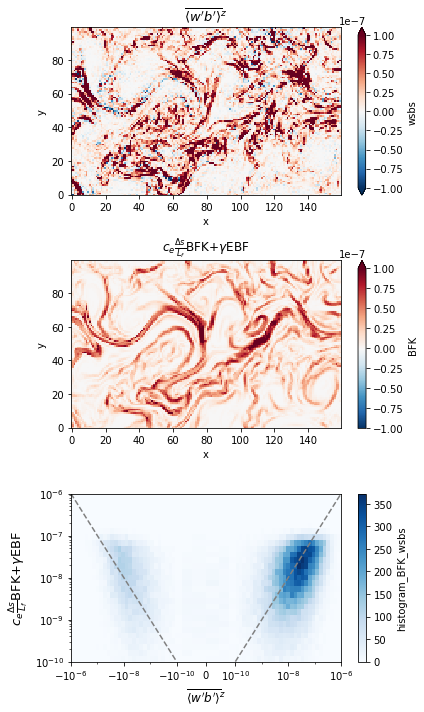

In [98]:
net = consts_EBF[:,0]*param + consts_EBF[:,-1]*EBF_b
net.name = 'BFK'
# wsbsb_ML.name = 'wsbs'

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML[::6][-1].plot(ax=ax1, vmax=1e-7, cmap='RdBu_r', rasterized=True)
(net[-1]).plot(ax=ax2, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r', rasterized=True)
xhist(net.chunk({'time_counter':1}), 
      wsbsb_ML[::6].chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xticks([-1e-6,-1e-8,-1e-10,0,1e-10,1e-8,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=12)
ax2.set_title(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \gamma$EBF",
              fontsize=12)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=13)
ax3.set_ylabel(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \gamma$EBF", 
              fontsize=13)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_BFK-EBFmeso_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
            % ncoars)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44396 remote=tcp://127.0.0.1:45640>
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-d9a8d6382b345fb4c3bcf479d9a4c62f', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d9a8d6382b345fb4c3bcf479d9a4c62f', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-d9a8d6382b345fb4c3bcf479d9a4c62f', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d9a8d6382b345fb4c3bcf479d9a4c62f', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-d9a8d6382b345fb4c3bcf479d9a4c62f', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d9a8d6382b345fb4c3bcf47

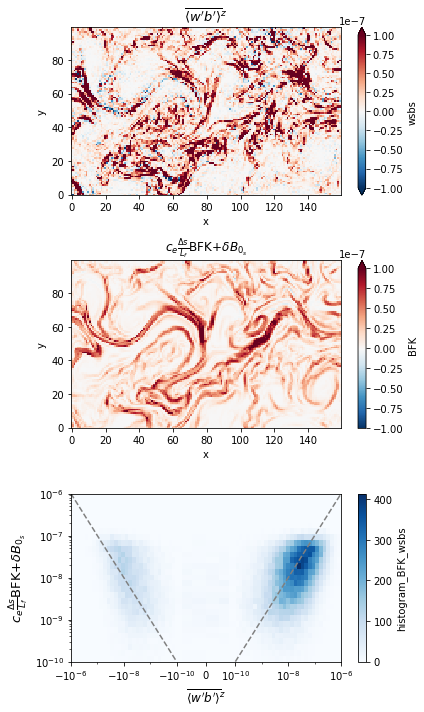

In [99]:
net = consts_Bo[:,0]*param + consts_Bo[:,-1]*Bos_b
net.name = 'BFK'
# wsbsb_ML.name = 'wsbs'

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML[::6][-1].plot(ax=ax1, vmax=1e-7, cmap='RdBu_r', rasterized=True)
(net[-1]).plot(ax=ax2, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r', rasterized=True)
xhist(net.chunk({'time_counter':1}), 
      wsbsb_ML[::6].chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xticks([-1e-6,-1e-8,-1e-10,0,1e-10,1e-8,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=12)
ax2.set_title(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s}$",
              fontsize=12)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=13)
ax3.set_ylabel(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s}$", 
              fontsize=13)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_BFK-Bomeso_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
            % ncoars)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44426 remote=tcp://127.0.0.1:45640>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44488 remote=tcp://127.0.0.1:45640>


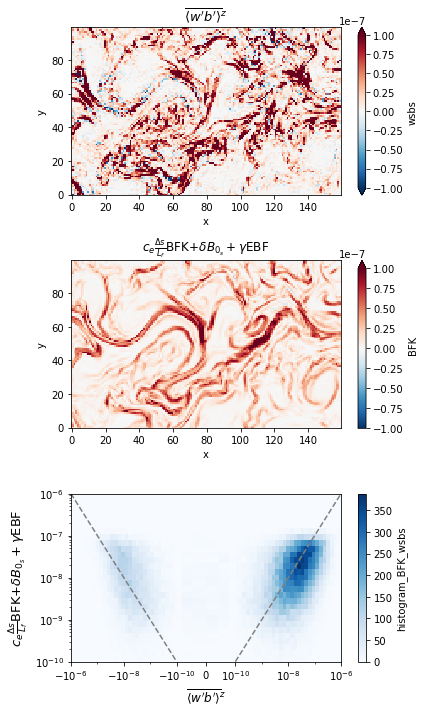

In [100]:
net = consts_tot[:,0]*param + consts_tot[:,1]*Bos_b + consts_tot[:,-1]*EBF_b
net.name = 'BFK'
# wsbsb_ML.name = 'wsbs'

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML[::6][-1].plot(ax=ax1, vmax=1e-7, cmap='RdBu_r', rasterized=True)
(net[-1]).plot(ax=ax2, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r', rasterized=True)
xhist(net.chunk({'time_counter':1}), 
      wsbsb_ML[::6].chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xticks([-1e-6,-1e-8,-1e-10,0,1e-10,1e-8,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=12)
ax2.set_title(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s} + \gamma$EBF",
              fontsize=12)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=13)
ax3.set_ylabel(r"$c_e \frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s} + \gamma$EBF", 
              fontsize=13)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_BFK-Bo-EBFmeso_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
            % ncoars)

distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-0fc08a95822d6418a4e8a7be5e13c994', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-0fc08a95822d6418a4e8a7be5e13c994', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-0fc08a95822d6418a4e8a7be5e13c994', 0, 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-0fc08a95822d6418a4e8a7be5e13c994', 0, 0, 0, 0)
NoneType: None
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:43354 remote=tcp://127.0.0.1:43362>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:43363 remote=tcp://127.0.0.1:43362>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:43372 remote=tcp://127.0.0.1:43362>
distributed.comm.t

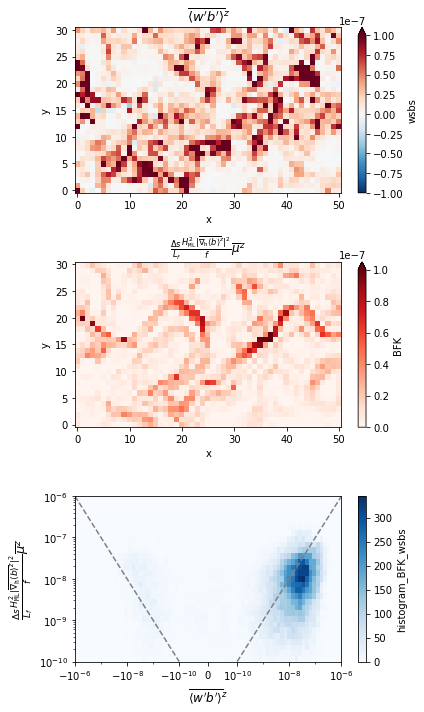

In [48]:
param = gradbb2H * ((mu.isel(y=slice(1,-1),x=slice(1,-1))
                     * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                    dims=['deptht','y','x','time_counter'],
                                    coords={'deptht':dsT.deptht.data,
                                            'time_counter':dsT.time_counter.data}
                                   ).isel(y=slice(1,-1),x=slice(1,-1))
                    ).sum('deptht') 
                    * MLD_b.isel(y=slice(1,-1),x=slice(1,-1))**-1
                   ) * boostb
param.name = 'BFK'
wsbsb_ML.name = 'wsbs'

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML[-1].isel(y=slice(1,-1),x=slice(1,-1)).plot(ax=ax1, vmax=1e-7, cmap='RdBu_r', rasterized=True)
(1e2*param[-1]).plot(ax=ax2, vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)
xhist(1e2*param.chunk({'time_counter':1}), 
      wsbsb_ML[:].isel(y=slice(1,-1),x=slice(1,-1)).chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xticks([-1e-6,-1e-8,-1e-10,0,1e-10,1e-8,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=12)
ax2.set_title(r"$\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle b\rangle}^z|^2}{f}$"
              + r"$\overline{\mu}^z$", 
               fontsize=12)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=13)
ax3.set_ylabel(r"$\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle b\rangle}^z|^2}{f}$"
               + r"$\overline{\mu}^z$", 
              fontsize=13)
# fig.suptitle(r"Nov. 2, 2009", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_Ncoars%02d_Jan-01-2010_GulfStreamPatch.pdf'
            % ncoars)